# Definitions

In [11]:
from transformers import AdamW, get_scheduler, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import TrainingArguments
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, balanced_accuracy_score
import os
import os
from datetime import datetime
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from transformers import TrainerCallback, TrainerState, TrainerControl
from transformers import Trainer, TrainingArguments
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

class Dataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def compute_metrics(pred):
    global conf_matrix
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    _, _, f1, _ = precision_recall_fscore_support(labels, preds, average=None)
    optimized_f1 = f1[-1]
    precision, recall, w_f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    macro_f1 = precision_recall_fscore_support(labels, preds, average='macro')[2]
    balanced_acc = balanced_accuracy_score(labels, preds)
    acc = accuracy_score(labels, preds)
    conf_matrix = confusion_matrix(labels, preds)

    return {
        'accuracy': acc,
        'optimized_f1': optimized_f1, # F1 score for the positive class
        'w_f1' : w_f1,   
        'macro_f1': macro_f1,  # Macro F1 score across all classes
        'balanced_accuracy': balanced_acc,  # Balanced accuracy score
        'precision': precision,
        'recall': recall,
    }

# Get labels
def get_labels(data, num_labels):
    if num_labels == 3:
        # Convert NF, FNR, and FR labels to 0, 1, and 2
        label_map = {'NF': 0, 'FNR': 1, 'FR': 2}
        return [label_map[label] for label in data['label']]
    elif num_labels == 2 and (data['label'][0] == 'Yes' or data['label'][0] == 'No'):
        # Convert Yes and No labels to 0 and 1
        label_map = {'Yes': 1, 'No': 0}
        return [label_map[label] for label in data['label']]
    else:
        # Convert NF and FNR to 0, and FR to 1
        label_map = {'NF': 0, 'FNR': 0, 'FR': 1}
        return [label_map[label] for label in data['label']]


class CosineAnnealingLRCallback(TrainerCallback):
    def __init__(self, lr_min, lr_max, warmup_steps, total_steps):
        super().__init__()
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

    def on_step_begin(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if state.global_step < self.warmup_steps:
            # Linear warmup
            lr = (self.lr_max - self.lr_min) / self.warmup_steps * state.global_step + self.lr_min
        else:
            # Cosine annealing
            progress = (state.global_step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            progress_tensor = torch.tensor(progress).float()  # Convert progress to a tensor
            lr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (1 + torch.cos(torch.pi * progress_tensor))
        
        # Ensure learning rate is a Python float
        lr = lr.item() if isinstance(lr, torch.Tensor) else lr

        # Update the learning rate for each parameter group in the optimizer
        for param_group in kwargs['optimizer'].param_groups:
            param_group['lr'] = lr
        
        # Log the updated learning rate
        state.log_history.append({'learning_rate': lr})

class ExponentialDecayCallback(TrainerCallback):
    def __init__(self, initial_lr, decay_rate, decay_steps):
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps  # This should be a specific interval at which you want the decay to happen

    def on_step_begin(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Calculate the new learning rate using float division
        step_ratio = state.global_step / float(self.decay_steps)  # Ensure this uses float division
        print('step_ratio:', step_ratio)
        new_lr = self.initial_lr * (self.decay_rate ** step_ratio)
        
        # Update the learning rate for each parameter group in the optimizer
        for param_group in kwargs['optimizer'].param_groups:
            param_group['lr'] = new_lr
        
        # Log the updated learning rate
        state.log_history.append({'learning_rate': new_lr})

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def create_optimizer_and_scheduler(self, num_training_steps):
        # Create the optimizer
        self.optimizer = optim.AdamW(self.model.parameters(), lr=3e-05, weight_decay=0.2)

        # Create the learning rate scheduler
        self.lr_scheduler = ExponentialLR(self.optimizer, gamma=0.5, last_epoch=-5)


# Specify training data and model params

In [12]:
### Specify training data
train = pd.read_csv('data_splits/opl_train.csv')
from transformers import TrainerCallback, TrainerState, TrainerControl
import torch

### Model params
model_name = "results/runs/2024-05-08_15-41-04-polfactbert/checkpoint-500"
tokenizer_name = 'dkleczek/bert-base-polish-cased-v1'
num_labels = 2
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
max_length = 512
batch_size = 16
batch_size_eval = 16
epochs = 5
learning_rate = 1e-5
eval_and_save_steps = 5
eval_and_save_strategy = 'no'
weight_decay = 0.2
warmup_ratio = 0.1
warmup_steps = 0
gradient_accumulation_steps = 1
lr_scheduler = 'cosine'
k_fold_splits = 5
metric_for_best_model = 'w_f1'

dt = datetime.now().strftime("%b%d_%H-%M-%S")

training_args = TrainingArguments(
    output_dir='./results/runs/' + dt,  # Directory where the best model will be saved.
    # Create the logging directory path
    logging_dir = './results/runs/' + dt,
    evaluation_strategy=eval_and_save_strategy, 
    eval_steps=eval_and_save_steps, 
    logging_steps=eval_and_save_steps,
    save_strategy=eval_and_save_strategy,
    save_steps=eval_and_save_steps*3,       
    save_total_limit=1, 
    gradient_accumulation_steps=gradient_accumulation_steps,
    load_best_model_at_end=True,  # Load the best model at the end of training.
    metric_for_best_model=metric_for_best_model,  # Use F1 to determine the best model.
    greater_is_better=True,  # Higher F1 score is better.
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size_eval,
    num_train_epochs=epochs,
    warmup_ratio=warmup_ratio,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    fp16=False,
    report_to='tensorboard',
    lr_scheduler_type=lr_scheduler,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at results/runs/2024-05-08_15-41-04-polfactbert/checkpoint-500 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train
### All training data - no validation

In [13]:
# WITHOUT KFOLD

# Tokenize and prepare the training set
tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
train_sentences = train['sentence'].tolist()
encoding_train = tokenizer(train_sentences, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
train_labels = get_labels(train, num_labels)

# Create dataset instances using the whole training data
train_dataset = Dataset(encoding_train['input_ids'], encoding_train['attention_mask'], train_labels)

# Re-initialize model for training with the whole dataset
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Calculate total training steps - for cosine LR
total_steps = (len(train_dataset) // (batch_size * gradient_accumulation_steps)) * epochs

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
    # callbacks=[ExponentialDecayCallback(initial_lr=3e-5, decay_rate=0.95, decay_steps=1)]
)

# Train the model using the entire dataset
train_result = trainer.train()
# Find the newest folder in ./results/runs/
runs = os.listdir('./results/runs/')
runs.sort()
latest_run = runs[-1]
print('latest_run:', latest_run)
# Save the best model from the run
trainer.save_model('./results/runs/'+latest_run+'/')

# After training, you might want to evaluate on a separate test set if available
# Example: test_results = trainer.evaluate(test_dataset)
# Print or save test results if needed

# Save training results to a file
with open('./results/runs/'+latest_run+'/training_results.txt', 'w') as file:
    file.write("Training results:\n")
    for key, value in train_result.metrics.items():
        file.write(f"{key}: {value}\n")

    file.write("\nTraining arguments:\n")
    for key, value in training_args.__dict__.items():
        file.write(f"{key}: {value}\n")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at results/runs/2024-05-08_15-41-04-polfactbert/checkpoint-500 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

{'loss': 0.5501, 'grad_norm': 5.485513210296631, 'learning_rate': 2.5e-06, 'epoch': 0.13}
{'loss': 0.6079, 'grad_norm': 5.52254581451416, 'learning_rate': 5e-06, 'epoch': 0.26}
{'loss': 0.6898, 'grad_norm': 10.503911972045898, 'learning_rate': 7.500000000000001e-06, 'epoch': 0.38}
{'loss': 0.5682, 'grad_norm': 4.175616264343262, 'learning_rate': 1e-05, 'epoch': 0.51}
{'loss': 0.5089, 'grad_norm': 3.724653720855713, 'learning_rate': 9.979871469976197e-06, 'epoch': 0.64}
{'loss': 0.5204, 'grad_norm': 4.804310321807861, 'learning_rate': 9.91964794299315e-06, 'epoch': 0.77}
{'loss': 0.4936, 'grad_norm': 3.5072779655456543, 'learning_rate': 9.819814303479268e-06, 'epoch': 0.9}
{'loss': 0.5001, 'grad_norm': 5.673922538757324, 'learning_rate': 9.681174353198687e-06, 'epoch': 1.03}
{'loss': 0.3945, 'grad_norm': 8.508270263671875, 'learning_rate': 9.504844339512096e-06, 'epoch': 1.15}
{'loss': 0.3256, 'grad_norm': 4.818964004516602, 'learning_rate': 9.292243968009332e-06, 'epoch': 1.28}
{'loss'

# Testing

In [39]:
# TEST ON ANOTHER MODEL
model_name = "results/runs/May08_21-45-18ZS_polbert_gmt_train_shorter_16"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
    # callbacks=[ExponentialDecayCallback(initial_lr=3e-5, decay_rate=0.95, decay_steps=1)]
)

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Test Accuracy: 0.8676470588235294
Test Precision: [0.92       0.72222222]
Test Recall: [0.90196078 0.76470588]
Test F1 Score: [0.91089109 0.74285714]
Test Weighted F1 Score: 0.8688826025459688
Test Macro F1 Score: 0.8268741159830268
Test Balanced Accuracy: 0.8333333333333333


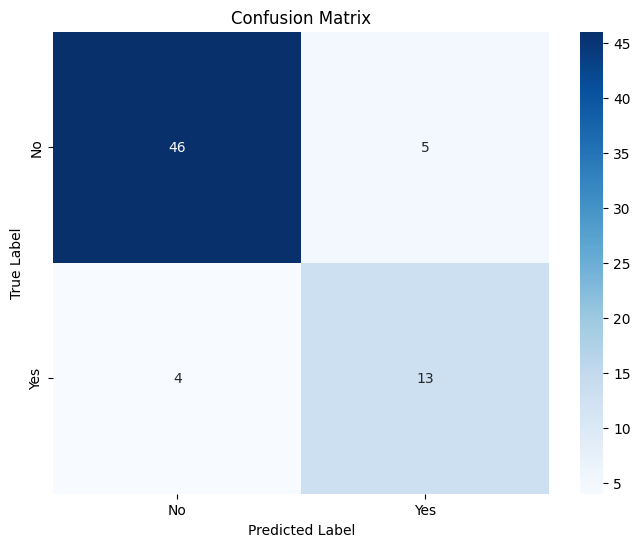

In [40]:
# TEST
test = pd.read_csv('data_splits/opl_test.csv')
train = pd.read_csv('data_splits/opl_train.csv')
# overwrite test by concatenating train and test
# test = pd.concat([train, test], ignore_index=True)
# Tokenize and prepare the training set
tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
test_sentences = test['sentence'].tolist()
encoding_test = tokenizer(test_sentences, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
test_labels = get_labels(test, num_labels)
# Create dataset instances using the whole training data
test_dataset = Dataset(encoding_test['input_ids'], encoding_test['attention_mask'], test_labels)


# Evaluate the model on the test set
test_results = trainer.evaluate(test_dataset)

# Extract predictions and true labels
predictions = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
# Replace 2 with 1 and 1 with 0
# predictions = np.where(predictions==1, 0, predictions)
# predictions = np.where(predictions==2, 1, predictions)


true_labels = test_dataset.labels  # Ensure your test_dataset has an attribute 'labels'

# Calculate standard metrics
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None)
_,_,w_f1,_= precision_recall_fscore_support(true_labels, predictions, average='weighted')
acc = accuracy_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

# Log or print the metrics and save those to a file
print(f"Test Accuracy: {acc}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")
print(f"Test Weighted F1 Score: {w_f1}")
print(f"Test Macro F1 Score: {precision_recall_fscore_support(true_labels, predictions, average='macro')[2]}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(true_labels, predictions)}")

# Save test results to a file
with open(model_name+'/test_results.txt', 'w') as file:
    file.write("Test results:\n")
    file.write(f"Accuracy: {acc}\n")
    file.write(f"Precision: {precision}\n")
    file.write(f"Recall: {recall}\n")
    file.write(f"F1: {f1}\n")
    file.write(f"Weighted F1: {w_f1}\n")
    file.write(f"Macro F1: {precision_recall_fscore_support(true_labels, predictions, average='macro')[2]}\n")
    file.write(f"Balanced Accuracy: {balanced_accuracy_score(true_labels, predictions)}\n")

# Plot and save the confusion matrix
if num_labels == 2:
    tick_labels = ['No', 'Yes']
else:
    tick_labels = ['NF', 'FNR', 'FR']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(f'{model_name}/test_confusion_matrix.png')
plt.show()

# # print sentences, true and predicted labels next to each other
# test['predicted_label'] = predictions
# test['predicted_label'] = test['predicted_label'].map({0: 'N', 1: 'Yes'})
# test

In [24]:
predictions

array([1, 2, 0, 2, 0, 2, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 2, 2, 0, 2, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 2, 0, 2, 1, 2, 2, 0, 1, 0, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 2, 1, 1, 2,
       0, 1])

# Train
### Cross validation with K folds

In [175]:
# WITH K FOLD
# Initialize the StratifiedKFold mechanism
skf = StratifiedKFold(n_splits=k_fold_splits, shuffle=True, random_state=42)


# Tokenize and prepare the training set
tokenizer = BertTokenizer.from_pretrained(model_name)
train_sentences = train['sentence'].tolist()
encoding_train = tokenizer(train_sentences, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
train_labels = get_labels(train, num_labels)

dt = datetime.now().strftime("%b%d_%H-%M-%S")
# Define the loop for stratified cross-validation
fold_results = []
for fold, (train_index, val_index) in enumerate(skf.split(train_sentences, train_labels)):
    # Split the data into training and validation sets for the current fold
    train_texts = encoding_train['input_ids'][train_index]
    train_masks = encoding_train['attention_mask'][train_index]
    train_dataset_labels = [train_labels[i] for i in train_index]
    
    val_texts = encoding_train['input_ids'][val_index]
    val_masks = encoding_train['attention_mask'][val_index]
    val_dataset_labels = [train_labels[i] for i in val_index]
    
    # Create dataset instances
    train_dataset = Dataset(train_texts, train_masks, train_dataset_labels)
    val_dataset = Dataset(val_texts, val_masks, val_dataset_labels)
    
    # Re-initialize model
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # Calculate total training steps - for cosine LR
    total_steps = (len(train_dataset) // (batch_size * gradient_accumulation_steps)) * epochs
    training_args = TrainingArguments(
    output_dir='./results/runs/' + str(dt) + '/fold-' + str(fold),  # Directory where the best model will be saved.
    # Create the logging directory path
    logging_dir = './results/runs/' + dt,
    evaluation_strategy=eval_and_save_strategy, 
    eval_steps=eval_and_save_steps, 
    logging_steps=eval_and_save_steps,
    save_strategy=eval_and_save_strategy,
    save_steps=eval_and_save_steps*3,       
    save_total_limit=1, 
    gradient_accumulation_steps=gradient_accumulation_steps,
    load_best_model_at_end=True,  # Load the best model at the end of training.
    metric_for_best_model=metric_for_best_model,  # Use F1 to determine the best model.
    greater_is_better=True,  # Higher F1 score is better.
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size_eval,
    num_train_epochs=epochs,
    warmup_ratio=warmup_ratio,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    fp16=False,
    report_to='tensorboard',
    lr_scheduler_type=lr_scheduler,
)

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        # callbacks=[ExponentialDecayCallback(initial_lr=3e-5, decay_rate=0.95, decay_steps=1)]
    )
    
    # Train the model
    train_result=trainer.train()
    # Find the newest folder in ./results/runs/
    runs = os.listdir('./results/runs/')
    runs.sort()
    latest_run = runs[-1]
    print('latest_run:',latest_run)
    # Save the best model from the run
    trainer.save_model('./results/runs/'+latest_run+'/')
    # After training, eval with validation set
    val_results = trainer.evaluate()
    
    # Store or print results
    fold_results.append(val_results)
    print(f"Results for fold {fold+1}: {val_results}")
    print(train_result)

# Save averages of all folds results
fold_results_avg = {key: np.mean([result[key] for result in fold_results]) for key in fold_results[0].keys()}

# Save the evaluation results to a file
with open('./results/runs/'+latest_run+'/fold_results.txt', 'w') as file:
    for i, fold in enumerate(fold_results):
        file.write(f"Weighted F1 for fold {i+1}: {fold['eval_w_f1']}\n")
    # add fold_results_avg underneath
    file.write("\nAverage results across all folds:\n")
    for key, value in fold_results_avg.items():
        file.write(f"{key}: {value}\n")
    # print all training args below
    file.write("\nTraining arguments:\n")
    for key, value in training_args.__dict__.items():
        file.write(f"{key}: {value}\n")
        


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dkleczek/bert-base-polish-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/155 [00:00<?, ?it/s]

{'loss': 1.1002, 'grad_norm': 7.626335620880127, 'learning_rate': 3.125e-06, 'epoch': 0.16}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 1.113070011138916, 'eval_accuracy': 0.3770491803278688, 'eval_optimized_f1': 0.3055555555555556, 'eval_w_f1': 0.3098816029143898, 'eval_macro_f1': 0.26851851851851855, 'eval_balanced_accuracy': 0.3192248852626211, 'eval_precision': 0.27008533204123936, 'eval_recall': 0.3770491803278688, 'eval_runtime': 0.6876, 'eval_samples_per_second': 177.434, 'eval_steps_per_second': 11.635, 'epoch': 0.16}
{'loss': 1.1088, 'grad_norm': 6.58169412612915, 'learning_rate': 6.25e-06, 'epoch': 0.32}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 1.0910314321517944, 'eval_accuracy': 0.4262295081967213, 'eval_optimized_f1': 0.3888888888888889, 'eval_w_f1': 0.3537730939370283, 'eval_macro_f1': 0.31058201058201057, 'eval_balanced_accuracy': 0.36511983681795, 'eval_precision': 0.31106086301111735, 'eval_recall': 0.4262295081967213, 'eval_runtime': 0.6441, 'eval_samples_per_second': 189.403, 'eval_steps_per_second': 12.42, 'epoch': 0.32}
{'loss': 1.1016, 'grad_norm': 6.843389987945557, 'learning_rate': 9.375000000000001e-06, 'epoch': 0.48}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 1.0688930749893188, 'eval_accuracy': 0.4344262295081967, 'eval_optimized_f1': 0.3103448275862069, 'eval_w_f1': 0.34236453201970446, 'eval_macro_f1': 0.2939244663382594, 'eval_balanced_accuracy': 0.35781064082950875, 'eval_precision': 0.3192315718691307, 'eval_recall': 0.4344262295081967, 'eval_runtime': 0.7081, 'eval_samples_per_second': 172.3, 'eval_steps_per_second': 11.298, 'epoch': 0.48}
{'loss': 1.0759, 'grad_norm': 12.121113777160645, 'learning_rate': 9.979581007037776e-06, 'epoch': 0.65}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.049034595489502, 'eval_accuracy': 0.3770491803278688, 'eval_optimized_f1': 0.32142857142857145, 'eval_w_f1': 0.3710981224943437, 'eval_macro_f1': 0.3510492332526231, 'eval_balanced_accuracy': 0.3509317100118987, 'eval_precision': 0.39291829826773744, 'eval_recall': 0.3770491803278688, 'eval_runtime': 0.6397, 'eval_samples_per_second': 190.703, 'eval_steps_per_second': 12.505, 'epoch': 0.65}
{'loss': 1.0324, 'grad_norm': 6.764675617218018, 'learning_rate': 9.896914594073703e-06, 'epoch': 0.81}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0147584676742554, 'eval_accuracy': 0.45901639344262296, 'eval_optimized_f1': 0.42424242424242425, 'eval_w_f1': 0.4419067281309481, 'eval_macro_f1': 0.4160059375113139, 'eval_balanced_accuracy': 0.4191685789563148, 'eval_precision': 0.4440217025468501, 'eval_recall': 0.45901639344262296, 'eval_runtime': 0.6518, 'eval_samples_per_second': 187.175, 'eval_steps_per_second': 12.274, 'epoch': 0.81}
{'loss': 1.0114, 'grad_norm': 6.984252452850342, 'learning_rate': 9.751778332739033e-06, 'epoch': 0.97}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 0.986106276512146, 'eval_accuracy': 0.5081967213114754, 'eval_optimized_f1': 0.5384615384615384, 'eval_w_f1': 0.4291468257702659, 'eval_macro_f1': 0.3834672789896671, 'eval_balanced_accuracy': 0.447050824409315, 'eval_precision': 0.3752326230001827, 'eval_recall': 0.5081967213114754, 'eval_runtime': 0.725, 'eval_samples_per_second': 168.269, 'eval_steps_per_second': 11.034, 'epoch': 0.97}
{'loss': 0.9973, 'grad_norm': 5.713638782501221, 'learning_rate': 9.546023723619387e-06, 'epoch': 1.13}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 0.9667481184005737, 'eval_accuracy': 0.5163934426229508, 'eval_optimized_f1': 0.5384615384615384, 'eval_w_f1': 0.43563079934501514, 'eval_macro_f1': 0.38844240336777647, 'eval_balanced_accuracy': 0.4533401325854156, 'eval_precision': 0.38059590978423447, 'eval_recall': 0.5163934426229508, 'eval_runtime': 0.6436, 'eval_samples_per_second': 189.563, 'eval_steps_per_second': 12.43, 'epoch': 1.13}
{'loss': 0.9285, 'grad_norm': 5.91475248336792, 'learning_rate': 9.28227557443528e-06, 'epoch': 1.29}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 0.9505445957183838, 'eval_accuracy': 0.5245901639344263, 'eval_optimized_f1': 0.5373134328358209, 'eval_w_f1': 0.4385916657526387, 'eval_macro_f1': 0.3905987304855036, 'eval_balanced_accuracy': 0.45147033826279115, 'eval_precision': 0.3991803278688525, 'eval_recall': 0.5245901639344263, 'eval_runtime': 0.6452, 'eval_samples_per_second': 189.095, 'eval_steps_per_second': 12.4, 'epoch': 1.29}
{'loss': 0.9354, 'grad_norm': 7.677905559539795, 'learning_rate': 8.963898515418885e-06, 'epoch': 1.45}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9285333156585693, 'eval_accuracy': 0.5573770491803278, 'eval_optimized_f1': 0.6666666666666666, 'eval_w_f1': 0.5343940855030536, 'eval_macro_f1': 0.5082007645825626, 'eval_balanced_accuracy': 0.5313084310725821, 'eval_precision': 0.5292234685073339, 'eval_recall': 0.5573770491803278, 'eval_runtime': 0.7375, 'eval_samples_per_second': 165.424, 'eval_steps_per_second': 10.847, 'epoch': 1.45}
{'loss': 0.8351, 'grad_norm': 6.04938268661499, 'learning_rate': 8.594954076788736e-06, 'epoch': 1.61}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9341356158256531, 'eval_accuracy': 0.5245901639344263, 'eval_optimized_f1': 0.6296296296296297, 'eval_w_f1': 0.4908203920776277, 'eval_macro_f1': 0.46806444662847563, 'eval_balanced_accuracy': 0.5156223440421553, 'eval_precision': 0.5343486236178454, 'eval_recall': 0.5245901639344263, 'eval_runtime': 0.6414, 'eval_samples_per_second': 190.203, 'eval_steps_per_second': 12.472, 'epoch': 1.61}
{'loss': 0.8748, 'grad_norm': 5.385953903198242, 'learning_rate': 8.180148875884312e-06, 'epoch': 1.77}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8930857181549072, 'eval_accuracy': 0.5655737704918032, 'eval_optimized_f1': 0.6666666666666666, 'eval_w_f1': 0.5221573789062681, 'eval_macro_f1': 0.4857453035023129, 'eval_balanced_accuracy': 0.5306550654428013, 'eval_precision': 0.5150327435163501, 'eval_recall': 0.5655737704918032, 'eval_runtime': 0.6462, 'eval_samples_per_second': 188.786, 'eval_steps_per_second': 12.379, 'epoch': 1.77}
{'loss': 0.8813, 'grad_norm': 7.884286403656006, 'learning_rate': 7.72477457493619e-06, 'epoch': 1.94}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8850876092910767, 'eval_accuracy': 0.5737704918032787, 'eval_optimized_f1': 0.631578947368421, 'eval_w_f1': 0.5041833157608141, 'eval_macro_f1': 0.457551967395278, 'eval_balanced_accuracy': 0.5096517508074112, 'eval_precision': 0.4897225725094577, 'eval_recall': 0.5737704918032787, 'eval_runtime': 0.9769, 'eval_samples_per_second': 124.89, 'eval_steps_per_second': 8.189, 'epoch': 1.94}
{'loss': 0.8161, 'grad_norm': 11.371411323547363, 'learning_rate': 7.234640375429427e-06, 'epoch': 2.1}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8624138832092285, 'eval_accuracy': 0.5901639344262295, 'eval_optimized_f1': 0.6666666666666666, 'eval_w_f1': 0.5244127457242211, 'eval_macro_f1': 0.4845598845598846, 'eval_balanced_accuracy': 0.5508350331463538, 'eval_precision': 0.6182818892816389, 'eval_recall': 0.5901639344262295, 'eval_runtime': 0.7476, 'eval_samples_per_second': 163.179, 'eval_steps_per_second': 10.7, 'epoch': 2.1}
{'loss': 0.7145, 'grad_norm': 6.4049153327941895, 'learning_rate': 6.715998910228296e-06, 'epoch': 2.26}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8875790238380432, 'eval_accuracy': 0.5655737704918032, 'eval_optimized_f1': 0.6428571428571429, 'eval_w_f1': 0.4917027417027417, 'eval_macro_f1': 0.44997594997595, 'eval_balanced_accuracy': 0.5359988526262112, 'eval_precision': 0.7100784034212402, 'eval_recall': 0.5655737704918032, 'eval_runtime': 0.9192, 'eval_samples_per_second': 132.727, 'eval_steps_per_second': 8.703, 'epoch': 2.26}
{'loss': 0.7753, 'grad_norm': 7.731354713439941, 'learning_rate': 6.175466478855161e-06, 'epoch': 2.42}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8587585091590881, 'eval_accuracy': 0.5737704918032787, 'eval_optimized_f1': 0.6481481481481481, 'eval_w_f1': 0.5016161291474696, 'eval_macro_f1': 0.45787944807552644, 'eval_balanced_accuracy': 0.5395684599694034, 'eval_precision': 0.582089728063934, 'eval_recall': 0.5737704918032787, 'eval_runtime': 0.655, 'eval_samples_per_second': 186.262, 'eval_steps_per_second': 12.214, 'epoch': 2.42}
{'loss': 0.7739, 'grad_norm': 5.9715576171875, 'learning_rate': 5.6199386434805615e-06, 'epoch': 2.58}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8201149702072144, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.6823529411764706, 'eval_w_f1': 0.6074998635396008, 'eval_macro_f1': 0.5796522382537921, 'eval_balanced_accuracy': 0.5940049719530851, 'eval_precision': 0.6071184621389539, 'eval_recall': 0.6229508196721312, 'eval_runtime': 0.6609, 'eval_samples_per_second': 184.594, 'eval_steps_per_second': 12.105, 'epoch': 2.58}
{'loss': 0.6886, 'grad_norm': 5.792102336883545, 'learning_rate': 5.0565022623649e-06, 'epoch': 2.74}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8246244192123413, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.676056338028169, 'eval_w_f1': 0.6237294769504421, 'eval_macro_f1': 0.6035097575003678, 'eval_balanced_accuracy': 0.6010432602413734, 'eval_precision': 0.62550480698986, 'eval_recall': 0.6229508196721312, 'eval_runtime': 0.7689, 'eval_samples_per_second': 158.665, 'eval_steps_per_second': 10.404, 'epoch': 2.74}
{'loss': 0.6666, 'grad_norm': 8.243131637573242, 'learning_rate': 4.49234508293946e-06, 'epoch': 2.9}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8065546154975891, 'eval_accuracy': 0.6065573770491803, 'eval_optimized_f1': 0.6904761904761905, 'eval_w_f1': 0.597988941195472, 'eval_macro_f1': 0.5738594288290029, 'eval_balanced_accuracy': 0.58555371409145, 'eval_precision': 0.5983165770399813, 'eval_recall': 0.6065573770491803, 'eval_runtime': 1.0677, 'eval_samples_per_second': 114.266, 'eval_steps_per_second': 7.493, 'epoch': 2.9}
{'loss': 0.6472, 'grad_norm': 8.78450870513916, 'learning_rate': 3.934664047846157e-06, 'epoch': 3.06}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8019294738769531, 'eval_accuracy': 0.639344262295082, 'eval_optimized_f1': 0.7045454545454546, 'eval_w_f1': 0.6259919185425454, 'eval_macro_f1': 0.6001353403314188, 'eval_balanced_accuracy': 0.6161503484616692, 'eval_precision': 0.6316070392389443, 'eval_recall': 0.639344262295082, 'eval_runtime': 0.8866, 'eval_samples_per_second': 137.609, 'eval_steps_per_second': 9.024, 'epoch': 3.06}
{'loss': 0.6715, 'grad_norm': 8.687746047973633, 'learning_rate': 3.3905734836741415e-06, 'epoch': 3.23}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7987289428710938, 'eval_accuracy': 0.6311475409836066, 'eval_optimized_f1': 0.7021276595744681, 'eval_w_f1': 0.5973275532745362, 'eval_macro_f1': 0.5642012833502196, 'eval_balanced_accuracy': 0.5987910079891212, 'eval_precision': 0.614106988783434, 'eval_recall': 0.6311475409836066, 'eval_runtime': 1.9433, 'eval_samples_per_second': 62.779, 'eval_steps_per_second': 4.117, 'epoch': 3.23}
{'loss': 0.6149, 'grad_norm': 9.015021324157715, 'learning_rate': 2.8670143436278753e-06, 'epoch': 3.39}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.792302668094635, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.6896551724137931, 'eval_w_f1': 0.5978514450815187, 'eval_macro_f1': 0.5658638934501004, 'eval_balanced_accuracy': 0.5884699558048615, 'eval_precision': 0.5980187604102745, 'eval_recall': 0.6229508196721312, 'eval_runtime': 0.7336, 'eval_samples_per_second': 166.297, 'eval_steps_per_second': 10.905, 'epoch': 3.39}
{'loss': 0.5961, 'grad_norm': 7.641002178192139, 'learning_rate': 2.3706656619162278e-06, 'epoch': 3.55}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7952262759208679, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.6966292134831461, 'eval_w_f1': 0.6040910217044498, 'eval_macro_f1': 0.574256041039067, 'eval_balanced_accuracy': 0.5953170151283359, 'eval_precision': 0.6071941992433796, 'eval_recall': 0.6229508196721312, 'eval_runtime': 1.2116, 'eval_samples_per_second': 100.695, 'eval_steps_per_second': 6.603, 'epoch': 3.55}
{'loss': 0.553, 'grad_norm': 5.542370796203613, 'learning_rate': 1.9078593494373365e-06, 'epoch': 3.71}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8081713914871216, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.7096774193548387, 'eval_w_f1': 0.6504555760194994, 'eval_macro_f1': 0.6297120257075763, 'eval_balanced_accuracy': 0.6465504419513853, 'eval_precision': 0.6791276346604216, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6649, 'eval_samples_per_second': 183.49, 'eval_steps_per_second': 12.032, 'epoch': 3.71}
{'loss': 0.6174, 'grad_norm': 6.620217323303223, 'learning_rate': 1.4844994177090871e-06, 'epoch': 3.87}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8041249513626099, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.7096774193548387, 'eval_w_f1': 0.6491391907878206, 'eval_macro_f1': 0.6297406751837269, 'eval_balanced_accuracy': 0.6465504419513853, 'eval_precision': 0.6753671388587421, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.7369, 'eval_samples_per_second': 165.558, 'eval_steps_per_second': 10.856, 'epoch': 3.87}
{'loss': 0.5541, 'grad_norm': 8.180707931518555, 'learning_rate': 1.1059866615040205e-06, 'epoch': 4.03}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7945342659950256, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.7111111111111111, 'eval_w_f1': 0.6329366063732881, 'eval_macro_f1': 0.6070476230012939, 'eval_balanced_accuracy': 0.6251593574706783, 'eval_precision': 0.6428842995596012, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6575, 'eval_samples_per_second': 185.539, 'eval_steps_per_second': 12.166, 'epoch': 4.03}
{'loss': 0.5519, 'grad_norm': 6.35853385925293, 'learning_rate': 7.771497610108981e-07, 'epoch': 4.19}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7896495461463928, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.7191011235955056, 'eval_w_f1': 0.6294300062824726, 'eval_macro_f1': 0.6010396824730849, 'eval_balanced_accuracy': 0.6210319989801122, 'eval_precision': 0.6348297604035309, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6904, 'eval_samples_per_second': 176.706, 'eval_steps_per_second': 11.587, 'epoch': 4.19}
{'loss': 0.5423, 'grad_norm': 6.834290981292725, 'learning_rate': 5.021836824513759e-07, 'epoch': 4.35}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7867617011070251, 'eval_accuracy': 0.6311475409836066, 'eval_optimized_f1': 0.6976744186046512, 'eval_w_f1': 0.6151129735949076, 'eval_macro_f1': 0.5870355279745363, 'eval_balanced_accuracy': 0.6030139809620941, 'eval_precision': 0.6155583292585635, 'eval_recall': 0.6311475409836066, 'eval_runtime': 0.6511, 'eval_samples_per_second': 187.386, 'eval_steps_per_second': 12.288, 'epoch': 4.35}
{'loss': 0.4873, 'grad_norm': 7.716494560241699, 'learning_rate': 2.8459616297395464e-07, 'epoch': 4.52}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.786359965801239, 'eval_accuracy': 0.6311475409836066, 'eval_optimized_f1': 0.6976744186046512, 'eval_w_f1': 0.6151129735949076, 'eval_macro_f1': 0.5870355279745363, 'eval_balanced_accuracy': 0.6030139809620941, 'eval_precision': 0.6155583292585635, 'eval_recall': 0.6311475409836066, 'eval_runtime': 0.8721, 'eval_samples_per_second': 139.893, 'eval_steps_per_second': 9.173, 'epoch': 4.52}
{'loss': 0.5246, 'grad_norm': 6.760857582092285, 'learning_rate': 1.2716296251644e-07, 'epoch': 4.68}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7856795787811279, 'eval_accuracy': 0.6311475409836066, 'eval_optimized_f1': 0.6976744186046512, 'eval_w_f1': 0.6151129735949076, 'eval_macro_f1': 0.5870355279745363, 'eval_balanced_accuracy': 0.6030139809620941, 'eval_precision': 0.6155583292585635, 'eval_recall': 0.6311475409836066, 'eval_runtime': 0.6449, 'eval_samples_per_second': 189.191, 'eval_steps_per_second': 12.406, 'epoch': 4.68}
{'loss': 0.6692, 'grad_norm': 18.516185760498047, 'learning_rate': 3.1892453488058803e-08, 'epoch': 4.84}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7857017517089844, 'eval_accuracy': 0.6311475409836066, 'eval_optimized_f1': 0.6976744186046512, 'eval_w_f1': 0.6151129735949076, 'eval_macro_f1': 0.5870355279745363, 'eval_balanced_accuracy': 0.6030139809620941, 'eval_precision': 0.6155583292585635, 'eval_recall': 0.6311475409836066, 'eval_runtime': 0.6807, 'eval_samples_per_second': 179.224, 'eval_steps_per_second': 11.752, 'epoch': 4.84}
{'loss': 0.5584, 'grad_norm': 16.694704055786133, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7857351303100586, 'eval_accuracy': 0.6311475409836066, 'eval_optimized_f1': 0.6976744186046512, 'eval_w_f1': 0.6151129735949076, 'eval_macro_f1': 0.5870355279745363, 'eval_balanced_accuracy': 0.6030139809620941, 'eval_precision': 0.6155583292585635, 'eval_recall': 0.6311475409836066, 'eval_runtime': 0.8202, 'eval_samples_per_second': 148.751, 'eval_steps_per_second': 9.754, 'epoch': 5.0}
{'train_runtime': 143.5786, 'train_samples_per_second': 16.994, 'train_steps_per_second': 1.08, 'train_loss': 0.7711362223471364, 'epoch': 5.0}
latest_run: May04_19-34-47


  0%|          | 0/8 [00:00<?, ?it/s]

Results for fold 1: {'eval_loss': 0.8041249513626099, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.7096774193548387, 'eval_w_f1': 0.6491391907878206, 'eval_macro_f1': 0.6297406751837269, 'eval_balanced_accuracy': 0.6465504419513853, 'eval_precision': 0.6753671388587421, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.7039, 'eval_samples_per_second': 173.321, 'eval_steps_per_second': 11.365, 'epoch': 5.0}
TrainOutput(global_step=155, training_loss=0.7711362223471364, metrics={'train_runtime': 143.5786, 'train_samples_per_second': 16.994, 'train_steps_per_second': 1.08, 'train_loss': 0.7711362223471364, 'epoch': 5.0})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dkleczek/bert-base-polish-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/155 [00:00<?, ?it/s]

{'loss': 1.1164, 'grad_norm': 8.680715560913086, 'learning_rate': 3.125e-06, 'epoch': 0.16}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.086330533027649, 'eval_accuracy': 0.4262295081967213, 'eval_optimized_f1': 0.09523809523809523, 'eval_w_f1': 0.3453406568160666, 'eval_macro_f1': 0.31185947852614515, 'eval_balanced_accuracy': 0.3661015519568151, 'eval_precision': 0.4301105315449578, 'eval_recall': 0.4262295081967213, 'eval_runtime': 0.9776, 'eval_samples_per_second': 124.794, 'eval_steps_per_second': 8.183, 'epoch': 0.16}
{'loss': 1.055, 'grad_norm': 7.237407207489014, 'learning_rate': 6.25e-06, 'epoch': 0.32}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0612066984176636, 'eval_accuracy': 0.4672131147540984, 'eval_optimized_f1': 0.21739130434782608, 'eval_w_f1': 0.3482351305002296, 'eval_macro_f1': 0.29938868442392863, 'eval_balanced_accuracy': 0.3811993927125506, 'eval_precision': 0.5199063231850117, 'eval_recall': 0.4672131147540984, 'eval_runtime': 0.8265, 'eval_samples_per_second': 147.614, 'eval_steps_per_second': 9.68, 'epoch': 0.32}
{'loss': 1.071, 'grad_norm': 7.460840702056885, 'learning_rate': 9.375000000000001e-06, 'epoch': 0.48}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 1.0404324531555176, 'eval_accuracy': 0.47540983606557374, 'eval_optimized_f1': 0.28, 'eval_w_f1': 0.3555798421372192, 'eval_macro_f1': 0.3032098765432099, 'eval_balanced_accuracy': 0.3883265856950067, 'eval_precision': 0.3793094883258818, 'eval_recall': 0.47540983606557374, 'eval_runtime': 0.6665, 'eval_samples_per_second': 183.037, 'eval_steps_per_second': 12.002, 'epoch': 0.48}
{'loss': 0.9867, 'grad_norm': 4.503650188446045, 'learning_rate': 9.979581007037776e-06, 'epoch': 0.65}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0206727981567383, 'eval_accuracy': 0.5081967213114754, 'eval_optimized_f1': 0.35294117647058826, 'eval_w_f1': 0.4028783495514451, 'eval_macro_f1': 0.35451574569221633, 'eval_balanced_accuracy': 0.42269736842105265, 'eval_precision': 0.683153519219093, 'eval_recall': 0.5081967213114754, 'eval_runtime': 0.7836, 'eval_samples_per_second': 155.696, 'eval_steps_per_second': 10.21, 'epoch': 0.65}
{'loss': 1.0475, 'grad_norm': 5.637308597564697, 'learning_rate': 9.896914594073703e-06, 'epoch': 0.81}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9925105571746826, 'eval_accuracy': 0.5163934426229508, 'eval_optimized_f1': 0.4444444444444444, 'eval_w_f1': 0.44283183443300217, 'eval_macro_f1': 0.40085525838950503, 'eval_balanced_accuracy': 0.4449224021592442, 'eval_precision': 0.5624043715846995, 'eval_recall': 0.5163934426229508, 'eval_runtime': 0.6373, 'eval_samples_per_second': 191.426, 'eval_steps_per_second': 12.553, 'epoch': 0.81}
{'loss': 0.9676, 'grad_norm': 5.862191677093506, 'learning_rate': 9.751778332739033e-06, 'epoch': 0.97}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9609012007713318, 'eval_accuracy': 0.5655737704918032, 'eval_optimized_f1': 0.5641025641025641, 'eval_w_f1': 0.5238509586803056, 'eval_macro_f1': 0.48361292623587704, 'eval_balanced_accuracy': 0.5102901484480432, 'eval_precision': 0.5205698672911788, 'eval_recall': 0.5655737704918032, 'eval_runtime': 0.6392, 'eval_samples_per_second': 190.865, 'eval_steps_per_second': 12.516, 'epoch': 0.97}
{'loss': 0.945, 'grad_norm': 5.30499792098999, 'learning_rate': 9.546023723619387e-06, 'epoch': 1.13}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9440362453460693, 'eval_accuracy': 0.5983606557377049, 'eval_optimized_f1': 0.6170212765957447, 'eval_w_f1': 0.5531835127231012, 'eval_macro_f1': 0.5142900674815568, 'eval_balanced_accuracy': 0.5524628879892038, 'eval_precision': 0.6001518278886993, 'eval_recall': 0.5983606557377049, 'eval_runtime': 0.6738, 'eval_samples_per_second': 181.058, 'eval_steps_per_second': 11.873, 'epoch': 1.13}
{'loss': 0.8872, 'grad_norm': 5.831521511077881, 'learning_rate': 9.28227557443528e-06, 'epoch': 1.29}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9178366661071777, 'eval_accuracy': 0.6065573770491803, 'eval_optimized_f1': 0.6153846153846154, 'eval_w_f1': 0.5486899257391062, 'eval_macro_f1': 0.5056980056980057, 'eval_balanced_accuracy': 0.5525050607287448, 'eval_precision': 0.6432415712960099, 'eval_recall': 0.6065573770491803, 'eval_runtime': 0.7708, 'eval_samples_per_second': 158.278, 'eval_steps_per_second': 10.379, 'epoch': 1.29}
{'loss': 0.8606, 'grad_norm': 8.29719352722168, 'learning_rate': 8.963898515418885e-06, 'epoch': 1.45}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9065672159194946, 'eval_accuracy': 0.5983606557377049, 'eval_optimized_f1': 0.631578947368421, 'eval_w_f1': 0.5413580954564562, 'eval_macro_f1': 0.4931991984623563, 'eval_balanced_accuracy': 0.5468117408906883, 'eval_precision': 0.540176047807478, 'eval_recall': 0.5983606557377049, 'eval_runtime': 0.64, 'eval_samples_per_second': 190.615, 'eval_steps_per_second': 12.499, 'epoch': 1.45}
{'loss': 0.8686, 'grad_norm': 6.138925552368164, 'learning_rate': 8.594954076788736e-06, 'epoch': 1.61}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9029543399810791, 'eval_accuracy': 0.5819672131147541, 'eval_optimized_f1': 0.6451612903225806, 'eval_w_f1': 0.5593092868250337, 'eval_macro_f1': 0.5260768657510911, 'eval_balanced_accuracy': 0.5500168690958165, 'eval_precision': 0.5617770207934143, 'eval_recall': 0.5819672131147541, 'eval_runtime': 0.6457, 'eval_samples_per_second': 188.945, 'eval_steps_per_second': 12.39, 'epoch': 1.61}
{'loss': 0.7482, 'grad_norm': 9.537266731262207, 'learning_rate': 8.180148875884312e-06, 'epoch': 1.77}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8820240497589111, 'eval_accuracy': 0.5901639344262295, 'eval_optimized_f1': 0.6111111111111112, 'eval_w_f1': 0.5689903574038055, 'eval_macro_f1': 0.533061309897468, 'eval_balanced_accuracy': 0.5415401484480432, 'eval_precision': 0.5626954209403582, 'eval_recall': 0.5901639344262295, 'eval_runtime': 0.7668, 'eval_samples_per_second': 159.095, 'eval_steps_per_second': 10.432, 'epoch': 1.77}
{'loss': 0.881, 'grad_norm': 6.140777587890625, 'learning_rate': 7.72477457493619e-06, 'epoch': 1.94}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9018079042434692, 'eval_accuracy': 0.5491803278688525, 'eval_optimized_f1': 0.4406779661016949, 'eval_w_f1': 0.5078995414096978, 'eval_macro_f1': 0.46524153860161105, 'eval_balanced_accuracy': 0.4842273954116059, 'eval_precision': 0.523328024261828, 'eval_recall': 0.5491803278688525, 'eval_runtime': 0.6433, 'eval_samples_per_second': 189.65, 'eval_steps_per_second': 12.436, 'epoch': 1.94}
{'loss': 0.753, 'grad_norm': 6.900768756866455, 'learning_rate': 7.234640375429427e-06, 'epoch': 2.1}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8554511070251465, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.6753246753246753, 'eval_w_f1': 0.5830664304192926, 'eval_macro_f1': 0.5450839385265615, 'eval_balanced_accuracy': 0.5686150472334682, 'eval_precision': 0.5825376808983366, 'eval_recall': 0.6229508196721312, 'eval_runtime': 0.642, 'eval_samples_per_second': 190.036, 'eval_steps_per_second': 12.461, 'epoch': 2.1}
{'loss': 0.6525, 'grad_norm': 6.2115936279296875, 'learning_rate': 6.715998910228296e-06, 'epoch': 2.26}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8349614143371582, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.6595744680851063, 'eval_w_f1': 0.54658775052157, 'eval_macro_f1': 0.4939782388441038, 'eval_balanced_accuracy': 0.5643977732793523, 'eval_precision': 0.5575396825396826, 'eval_recall': 0.6229508196721312, 'eval_runtime': 0.7255, 'eval_samples_per_second': 168.152, 'eval_steps_per_second': 11.026, 'epoch': 2.26}
{'loss': 0.7375, 'grad_norm': 7.213027477264404, 'learning_rate': 6.175466478855161e-06, 'epoch': 2.42}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8247129321098328, 'eval_accuracy': 0.639344262295082, 'eval_optimized_f1': 0.6736842105263158, 'eval_w_f1': 0.5730869042344452, 'eval_macro_f1': 0.5225022014495698, 'eval_balanced_accuracy': 0.5835863697705803, 'eval_precision': 0.5923497267759563, 'eval_recall': 0.639344262295082, 'eval_runtime': 0.6424, 'eval_samples_per_second': 189.901, 'eval_steps_per_second': 12.453, 'epoch': 2.42}
{'loss': 0.6898, 'grad_norm': 6.509488582611084, 'learning_rate': 5.6199386434805615e-06, 'epoch': 2.58}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8106821775436401, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.6976744186046512, 'eval_w_f1': 0.6222628881264032, 'eval_macro_f1': 0.5851507321274764, 'eval_balanced_accuracy': 0.605305330634278, 'eval_precision': 0.6163479052823315, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.7119, 'eval_samples_per_second': 171.368, 'eval_steps_per_second': 11.237, 'epoch': 2.58}
{'loss': 0.6177, 'grad_norm': 4.6626434326171875, 'learning_rate': 5.0565022623649e-06, 'epoch': 2.74}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8024122714996338, 'eval_accuracy': 0.6639344262295082, 'eval_optimized_f1': 0.6987951807228916, 'eval_w_f1': 0.6494139231628179, 'eval_macro_f1': 0.6180707600217415, 'eval_balanced_accuracy': 0.6277834008097166, 'eval_precision': 0.645437986421593, 'eval_recall': 0.6639344262295082, 'eval_runtime': 0.8829, 'eval_samples_per_second': 138.183, 'eval_steps_per_second': 9.061, 'epoch': 2.74}
{'loss': 0.6554, 'grad_norm': 8.135431289672852, 'learning_rate': 4.49234508293946e-06, 'epoch': 2.9}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7978247404098511, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.6829268292682927, 'eval_w_f1': 0.64270502504181, 'eval_macro_f1': 0.6105366406255396, 'eval_balanced_accuracy': 0.6190114709851552, 'eval_precision': 0.6377373161407373, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6641, 'eval_samples_per_second': 183.714, 'eval_steps_per_second': 12.047, 'epoch': 2.9}
{'loss': 0.5187, 'grad_norm': 6.214679718017578, 'learning_rate': 3.934664047846157e-06, 'epoch': 3.06}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7925084233283997, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.7058823529411765, 'eval_w_f1': 0.632042981126877, 'eval_macro_f1': 0.6003734827264239, 'eval_balanced_accuracy': 0.6133181511470985, 'eval_precision': 0.6277992726124032, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6711, 'eval_samples_per_second': 181.79, 'eval_steps_per_second': 11.921, 'epoch': 3.06}
{'loss': 0.5451, 'grad_norm': 6.494166851043701, 'learning_rate': 3.3905734836741415e-06, 'epoch': 3.23}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7846195697784424, 'eval_accuracy': 0.680327868852459, 'eval_optimized_f1': 0.7209302325581395, 'eval_w_f1': 0.6583832479066942, 'eval_macro_f1': 0.6257421762848119, 'eval_balanced_accuracy': 0.6413208502024291, 'eval_precision': 0.6595921155347385, 'eval_recall': 0.680327868852459, 'eval_runtime': 0.6629, 'eval_samples_per_second': 184.042, 'eval_steps_per_second': 12.068, 'epoch': 3.23}
{'loss': 0.5641, 'grad_norm': 8.833658218383789, 'learning_rate': 2.8670143436278753e-06, 'epoch': 3.39}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7848251461982727, 'eval_accuracy': 0.6885245901639344, 'eval_optimized_f1': 0.7272727272727273, 'eval_w_f1': 0.6642932052768118, 'eval_macro_f1': 0.6328563411896745, 'eval_balanced_accuracy': 0.6500927800269906, 'eval_precision': 0.674168618266979, 'eval_recall': 0.6885245901639344, 'eval_runtime': 0.7865, 'eval_samples_per_second': 155.11, 'eval_steps_per_second': 10.171, 'epoch': 3.39}
{'loss': 0.5264, 'grad_norm': 6.711289405822754, 'learning_rate': 2.3706656619162278e-06, 'epoch': 3.55}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7773147225379944, 'eval_accuracy': 0.6967213114754098, 'eval_optimized_f1': 0.735632183908046, 'eval_w_f1': 0.6659559010924312, 'eval_macro_f1': 0.6314230272251261, 'eval_balanced_accuracy': 0.6524966261808367, 'eval_precision': 0.6783857193891726, 'eval_recall': 0.6967213114754098, 'eval_runtime': 0.9659, 'eval_samples_per_second': 126.313, 'eval_steps_per_second': 8.283, 'epoch': 3.55}
{'loss': 0.5775, 'grad_norm': 10.178947448730469, 'learning_rate': 1.9078593494373365e-06, 'epoch': 3.71}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.776093065738678, 'eval_accuracy': 0.680327868852459, 'eval_optimized_f1': 0.7058823529411765, 'eval_w_f1': 0.6528881822999469, 'eval_macro_f1': 0.6166754990284402, 'eval_balanced_accuracy': 0.634952766531714, 'eval_precision': 0.6550519352302353, 'eval_recall': 0.680327868852459, 'eval_runtime': 0.6584, 'eval_samples_per_second': 185.284, 'eval_steps_per_second': 12.15, 'epoch': 3.71}
{'loss': 0.5212, 'grad_norm': 8.213662147521973, 'learning_rate': 1.4844994177090871e-06, 'epoch': 3.87}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7782642841339111, 'eval_accuracy': 0.6721311475409836, 'eval_optimized_f1': 0.7058823529411765, 'eval_w_f1': 0.6518447087395979, 'eval_macro_f1': 0.6183732752360204, 'eval_balanced_accuracy': 0.6325489203778677, 'eval_precision': 0.650342502576637, 'eval_recall': 0.6721311475409836, 'eval_runtime': 0.9166, 'eval_samples_per_second': 133.106, 'eval_steps_per_second': 8.728, 'epoch': 3.87}
{'loss': 0.4879, 'grad_norm': 6.515876770019531, 'learning_rate': 1.1059866615040205e-06, 'epoch': 4.03}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7814568877220154, 'eval_accuracy': 0.6639344262295082, 'eval_optimized_f1': 0.6904761904761905, 'eval_w_f1': 0.6452657846100469, 'eval_macro_f1': 0.6109754443087777, 'eval_balanced_accuracy': 0.6237769905533064, 'eval_precision': 0.6416810915385398, 'eval_recall': 0.6639344262295082, 'eval_runtime': 0.9528, 'eval_samples_per_second': 128.042, 'eval_steps_per_second': 8.396, 'epoch': 4.03}
{'loss': 0.5196, 'grad_norm': 5.204329967498779, 'learning_rate': 7.771497610108981e-07, 'epoch': 4.19}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7830760478973389, 'eval_accuracy': 0.6721311475409836, 'eval_optimized_f1': 0.6987951807228916, 'eval_w_f1': 0.6560417702704138, 'eval_macro_f1': 0.6241499891950751, 'eval_balanced_accuracy': 0.634193657219973, 'eval_precision': 0.6529143897996358, 'eval_recall': 0.6721311475409836, 'eval_runtime': 0.6706, 'eval_samples_per_second': 181.926, 'eval_steps_per_second': 11.93, 'epoch': 4.19}
{'loss': 0.5806, 'grad_norm': 6.788990497589111, 'learning_rate': 5.021836824513759e-07, 'epoch': 4.35}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7818018198013306, 'eval_accuracy': 0.6639344262295082, 'eval_optimized_f1': 0.6904761904761905, 'eval_w_f1': 0.6452657846100469, 'eval_macro_f1': 0.6109754443087777, 'eval_balanced_accuracy': 0.6237769905533064, 'eval_precision': 0.6416810915385398, 'eval_recall': 0.6639344262295082, 'eval_runtime': 0.6717, 'eval_samples_per_second': 181.63, 'eval_steps_per_second': 11.91, 'epoch': 4.35}
{'loss': 0.4065, 'grad_norm': 6.1347575187683105, 'learning_rate': 2.8459616297395464e-07, 'epoch': 4.52}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7817145586013794, 'eval_accuracy': 0.6639344262295082, 'eval_optimized_f1': 0.6904761904761905, 'eval_w_f1': 0.6452657846100469, 'eval_macro_f1': 0.6109754443087777, 'eval_balanced_accuracy': 0.6237769905533064, 'eval_precision': 0.6416810915385398, 'eval_recall': 0.6639344262295082, 'eval_runtime': 1.8019, 'eval_samples_per_second': 67.705, 'eval_steps_per_second': 4.44, 'epoch': 4.52}
{'loss': 0.4919, 'grad_norm': 4.431088924407959, 'learning_rate': 1.2716296251644e-07, 'epoch': 4.68}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7816106677055359, 'eval_accuracy': 0.6721311475409836, 'eval_optimized_f1': 0.6987951807228916, 'eval_w_f1': 0.6560417702704138, 'eval_macro_f1': 0.6241499891950751, 'eval_balanced_accuracy': 0.634193657219973, 'eval_precision': 0.6529143897996358, 'eval_recall': 0.6721311475409836, 'eval_runtime': 0.8703, 'eval_samples_per_second': 140.189, 'eval_steps_per_second': 9.193, 'epoch': 4.68}
{'loss': 0.473, 'grad_norm': 8.264969825744629, 'learning_rate': 3.1892453488058803e-08, 'epoch': 4.84}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7816344499588013, 'eval_accuracy': 0.6639344262295082, 'eval_optimized_f1': 0.6904761904761905, 'eval_w_f1': 0.6452657846100469, 'eval_macro_f1': 0.6109754443087777, 'eval_balanced_accuracy': 0.6237769905533064, 'eval_precision': 0.6416810915385398, 'eval_recall': 0.6639344262295082, 'eval_runtime': 0.6872, 'eval_samples_per_second': 177.535, 'eval_steps_per_second': 11.642, 'epoch': 4.84}
{'loss': 0.4873, 'grad_norm': 18.395837783813477, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7816612124443054, 'eval_accuracy': 0.6639344262295082, 'eval_optimized_f1': 0.6904761904761905, 'eval_w_f1': 0.6452657846100469, 'eval_macro_f1': 0.6109754443087777, 'eval_balanced_accuracy': 0.6237769905533064, 'eval_precision': 0.6416810915385398, 'eval_recall': 0.6639344262295082, 'eval_runtime': 0.7688, 'eval_samples_per_second': 158.686, 'eval_steps_per_second': 10.406, 'epoch': 5.0}
{'train_runtime': 144.1632, 'train_samples_per_second': 16.925, 'train_steps_per_second': 1.075, 'train_loss': 0.717433221878544, 'epoch': 5.0}
latest_run: May04_19-34-47


  0%|          | 0/8 [00:00<?, ?it/s]

Results for fold 2: {'eval_loss': 0.7848251461982727, 'eval_accuracy': 0.6885245901639344, 'eval_optimized_f1': 0.7272727272727273, 'eval_w_f1': 0.6642932052768118, 'eval_macro_f1': 0.6328563411896745, 'eval_balanced_accuracy': 0.6500927800269906, 'eval_precision': 0.674168618266979, 'eval_recall': 0.6885245901639344, 'eval_runtime': 0.7163, 'eval_samples_per_second': 170.309, 'eval_steps_per_second': 11.168, 'epoch': 5.0}
TrainOutput(global_step=155, training_loss=0.717433221878544, metrics={'train_runtime': 144.1632, 'train_samples_per_second': 16.925, 'train_steps_per_second': 1.075, 'train_loss': 0.717433221878544, 'epoch': 5.0})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dkleczek/bert-base-polish-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/155 [00:00<?, ?it/s]

{'loss': 1.1191, 'grad_norm': 5.22940731048584, 'learning_rate': 3.125e-06, 'epoch': 0.16}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0478637218475342, 'eval_accuracy': 0.45901639344262296, 'eval_optimized_f1': 0.15, 'eval_w_f1': 0.3834017591093311, 'eval_macro_f1': 0.34729203195012665, 'eval_balanced_accuracy': 0.39629664629664635, 'eval_precision': 0.5927470202985803, 'eval_recall': 0.45901639344262296, 'eval_runtime': 0.7704, 'eval_samples_per_second': 158.368, 'eval_steps_per_second': 10.385, 'epoch': 0.16}
{'loss': 1.061, 'grad_norm': 5.356017589569092, 'learning_rate': 6.25e-06, 'epoch': 0.32}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0222773551940918, 'eval_accuracy': 0.48360655737704916, 'eval_optimized_f1': 0.27906976744186046, 'eval_w_f1': 0.37982904021712005, 'eval_macro_f1': 0.33669993216741384, 'eval_balanced_accuracy': 0.4011791511791512, 'eval_precision': 0.6073105892778023, 'eval_recall': 0.48360655737704916, 'eval_runtime': 0.6561, 'eval_samples_per_second': 185.959, 'eval_steps_per_second': 12.194, 'epoch': 0.32}
{'loss': 1.0297, 'grad_norm': 5.337825775146484, 'learning_rate': 9.375000000000001e-06, 'epoch': 0.48}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 1.006596326828003, 'eval_accuracy': 0.5245901639344263, 'eval_optimized_f1': 0.48148148148148145, 'eval_w_f1': 0.4229365106988579, 'eval_macro_f1': 0.37705433671463395, 'eval_balanced_accuracy': 0.44404019404019407, 'eval_precision': 0.4389447582311613, 'eval_recall': 0.5245901639344263, 'eval_runtime': 0.6612, 'eval_samples_per_second': 184.506, 'eval_steps_per_second': 12.099, 'epoch': 0.48}
{'loss': 1.057, 'grad_norm': 6.311059951782227, 'learning_rate': 9.979581007037776e-06, 'epoch': 0.65}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 0.9916703104972839, 'eval_accuracy': 0.5655737704918032, 'eval_optimized_f1': 0.6101694915254238, 'eval_w_f1': 0.47107383629955685, 'eval_macro_f1': 0.4270740410347904, 'eval_balanced_accuracy': 0.4890852390852391, 'eval_precision': 0.4655141579731744, 'eval_recall': 0.5655737704918032, 'eval_runtime': 0.6598, 'eval_samples_per_second': 184.892, 'eval_steps_per_second': 12.124, 'epoch': 0.65}
{'loss': 1.0479, 'grad_norm': 5.308147430419922, 'learning_rate': 9.896914594073703e-06, 'epoch': 0.81}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.938193142414093, 'eval_accuracy': 0.6065573770491803, 'eval_optimized_f1': 0.7027027027027027, 'eval_w_f1': 0.5139826422372228, 'eval_macro_f1': 0.4695283518812931, 'eval_balanced_accuracy': 0.541926541926542, 'eval_precision': 0.45667447306791564, 'eval_recall': 0.6065573770491803, 'eval_runtime': 0.6662, 'eval_samples_per_second': 183.118, 'eval_steps_per_second': 12.008, 'epoch': 0.81}
{'loss': 1.0563, 'grad_norm': 5.918320655822754, 'learning_rate': 9.751778332739033e-06, 'epoch': 0.97}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9105096459388733, 'eval_accuracy': 0.6721311475409836, 'eval_optimized_f1': 0.7209302325581395, 'eval_w_f1': 0.6371264841304831, 'eval_macro_f1': 0.6038651219254881, 'eval_balanced_accuracy': 0.632037632037632, 'eval_precision': 0.6449821662479941, 'eval_recall': 0.6721311475409836, 'eval_runtime': 0.6368, 'eval_samples_per_second': 191.569, 'eval_steps_per_second': 12.562, 'epoch': 0.97}
{'loss': 0.9807, 'grad_norm': 5.188410758972168, 'learning_rate': 9.546023723619387e-06, 'epoch': 1.13}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8898507356643677, 'eval_accuracy': 0.7131147540983607, 'eval_optimized_f1': 0.7323943661971831, 'eval_w_f1': 0.7122375743660677, 'eval_macro_f1': 0.6938624098029126, 'eval_balanced_accuracy': 0.6916934416934417, 'eval_precision': 0.7126939598492155, 'eval_recall': 0.7131147540983607, 'eval_runtime': 0.6472, 'eval_samples_per_second': 188.517, 'eval_steps_per_second': 12.362, 'epoch': 1.13}
{'loss': 0.8755, 'grad_norm': 5.111783981323242, 'learning_rate': 9.28227557443528e-06, 'epoch': 1.29}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8566716909408569, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.7246376811594203, 'eval_w_f1': 0.6192848105112522, 'eval_macro_f1': 0.5910571845860016, 'eval_balanced_accuracy': 0.6036246036246037, 'eval_precision': 0.6482874195476654, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6714, 'eval_samples_per_second': 181.722, 'eval_steps_per_second': 11.916, 'epoch': 1.29}
{'loss': 0.8922, 'grad_norm': 6.446534633636475, 'learning_rate': 8.963898515418885e-06, 'epoch': 1.45}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8640396595001221, 'eval_accuracy': 0.5819672131147541, 'eval_optimized_f1': 0.6440677966101694, 'eval_w_f1': 0.49085116235991477, 'eval_macro_f1': 0.4458003766478343, 'eval_balanced_accuracy': 0.5045045045045046, 'eval_precision': 0.48808509991179777, 'eval_recall': 0.5819672131147541, 'eval_runtime': 0.6788, 'eval_samples_per_second': 179.721, 'eval_steps_per_second': 11.785, 'epoch': 1.45}
{'loss': 0.8669, 'grad_norm': 6.712155342102051, 'learning_rate': 8.594954076788736e-06, 'epoch': 1.61}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8077747821807861, 'eval_accuracy': 0.6721311475409836, 'eval_optimized_f1': 0.7246376811594203, 'eval_w_f1': 0.6372535043953433, 'eval_macro_f1': 0.6113464635203766, 'eval_balanced_accuracy': 0.6201358701358701, 'eval_precision': 0.6850239071038251, 'eval_recall': 0.6721311475409836, 'eval_runtime': 0.6686, 'eval_samples_per_second': 182.465, 'eval_steps_per_second': 11.965, 'epoch': 1.61}
{'loss': 0.7937, 'grad_norm': 5.258101463317871, 'learning_rate': 8.180148875884312e-06, 'epoch': 1.77}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7826186418533325, 'eval_accuracy': 0.7049180327868853, 'eval_optimized_f1': 0.7333333333333333, 'eval_w_f1': 0.6489574345700315, 'eval_macro_f1': 0.6084795321637427, 'eval_balanced_accuracy': 0.6554946554946556, 'eval_precision': 0.7120264666935591, 'eval_recall': 0.7049180327868853, 'eval_runtime': 0.6571, 'eval_samples_per_second': 185.656, 'eval_steps_per_second': 12.174, 'epoch': 1.77}
{'loss': 0.8172, 'grad_norm': 9.745285987854004, 'learning_rate': 7.72477457493619e-06, 'epoch': 1.94}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7870426774024963, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.7, 'eval_w_f1': 0.6128076837420685, 'eval_macro_f1': 0.5748791158185586, 'eval_balanced_accuracy': 0.6222306222306222, 'eval_precision': 0.6516765176015762, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6991, 'eval_samples_per_second': 174.501, 'eval_steps_per_second': 11.443, 'epoch': 1.94}
{'loss': 0.7981, 'grad_norm': 10.87281608581543, 'learning_rate': 7.234640375429427e-06, 'epoch': 2.1}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7356787919998169, 'eval_accuracy': 0.7377049180327869, 'eval_optimized_f1': 0.7857142857142857, 'eval_w_f1': 0.702296100193463, 'eval_macro_f1': 0.6734989648033126, 'eval_balanced_accuracy': 0.695898695898696, 'eval_precision': 0.7405555001910077, 'eval_recall': 0.7377049180327869, 'eval_runtime': 0.7146, 'eval_samples_per_second': 170.714, 'eval_steps_per_second': 11.194, 'epoch': 2.1}
{'loss': 0.6453, 'grad_norm': 6.1973443031311035, 'learning_rate': 6.715998910228296e-06, 'epoch': 2.26}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7237287759780884, 'eval_accuracy': 0.7131147540983607, 'eval_optimized_f1': 0.7804878048780488, 'eval_w_f1': 0.6610843265999385, 'eval_macro_f1': 0.627696029026406, 'eval_balanced_accuracy': 0.662996912996913, 'eval_precision': 0.7212184208442228, 'eval_recall': 0.7131147540983607, 'eval_runtime': 0.6425, 'eval_samples_per_second': 189.875, 'eval_steps_per_second': 12.451, 'epoch': 2.26}
{'loss': 0.5803, 'grad_norm': 5.9810614585876465, 'learning_rate': 6.175466478855161e-06, 'epoch': 2.42}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7220701575279236, 'eval_accuracy': 0.7131147540983607, 'eval_optimized_f1': 0.7804878048780488, 'eval_w_f1': 0.6610843265999385, 'eval_macro_f1': 0.627696029026406, 'eval_balanced_accuracy': 0.662996912996913, 'eval_precision': 0.7212184208442228, 'eval_recall': 0.7131147540983607, 'eval_runtime': 0.675, 'eval_samples_per_second': 180.742, 'eval_steps_per_second': 11.852, 'epoch': 2.42}
{'loss': 0.6559, 'grad_norm': 5.7249345779418945, 'learning_rate': 5.6199386434805615e-06, 'epoch': 2.58}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7011163234710693, 'eval_accuracy': 0.7377049180327869, 'eval_optimized_f1': 0.7857142857142857, 'eval_w_f1': 0.7030651289663932, 'eval_macro_f1': 0.6730412988994224, 'eval_balanced_accuracy': 0.695898695898696, 'eval_precision': 0.7301880472667065, 'eval_recall': 0.7377049180327869, 'eval_runtime': 0.7707, 'eval_samples_per_second': 158.299, 'eval_steps_per_second': 10.38, 'epoch': 2.58}
{'loss': 0.5961, 'grad_norm': 6.859516143798828, 'learning_rate': 5.0565022623649e-06, 'epoch': 2.74}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6951905488967896, 'eval_accuracy': 0.7295081967213115, 'eval_optimized_f1': 0.7857142857142857, 'eval_w_f1': 0.6964456033763163, 'eval_macro_f1': 0.6668504720660623, 'eval_balanced_accuracy': 0.6894884394884396, 'eval_precision': 0.715234285975679, 'eval_recall': 0.7295081967213115, 'eval_runtime': 0.6685, 'eval_samples_per_second': 182.501, 'eval_steps_per_second': 11.967, 'epoch': 2.74}
{'loss': 0.6519, 'grad_norm': 6.089695453643799, 'learning_rate': 4.49234508293946e-06, 'epoch': 2.9}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6846251487731934, 'eval_accuracy': 0.7295081967213115, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.701683280462096, 'eval_macro_f1': 0.6749241865420866, 'eval_balanced_accuracy': 0.6931791931791932, 'eval_precision': 0.7134028272748872, 'eval_recall': 0.7295081967213115, 'eval_runtime': 0.6497, 'eval_samples_per_second': 187.786, 'eval_steps_per_second': 12.314, 'epoch': 2.9}
{'loss': 0.539, 'grad_norm': 5.8718791007995605, 'learning_rate': 3.934664047846157e-06, 'epoch': 3.06}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6779107451438904, 'eval_accuracy': 0.7295081967213115, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.701683280462096, 'eval_macro_f1': 0.6749241865420866, 'eval_balanced_accuracy': 0.6931791931791932, 'eval_precision': 0.7134028272748872, 'eval_recall': 0.7295081967213115, 'eval_runtime': 0.7479, 'eval_samples_per_second': 163.129, 'eval_steps_per_second': 10.697, 'epoch': 3.06}
{'loss': 0.6081, 'grad_norm': 9.45124626159668, 'learning_rate': 3.3905734836741415e-06, 'epoch': 3.23}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6730442643165588, 'eval_accuracy': 0.7377049180327869, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7179363589694341, 'eval_macro_f1': 0.6941357526081745, 'eval_balanced_accuracy': 0.7069709569709571, 'eval_precision': 0.7249034024834002, 'eval_recall': 0.7377049180327869, 'eval_runtime': 0.6409, 'eval_samples_per_second': 190.366, 'eval_steps_per_second': 12.483, 'epoch': 3.23}
{'loss': 0.5611, 'grad_norm': 6.105034828186035, 'learning_rate': 2.8670143436278753e-06, 'epoch': 3.39}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6673665642738342, 'eval_accuracy': 0.7295081967213115, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7065773394269635, 'eval_macro_f1': 0.6815783633643308, 'eval_balanced_accuracy': 0.6968699468699469, 'eval_precision': 0.7135653484733043, 'eval_recall': 0.7295081967213115, 'eval_runtime': 0.6371, 'eval_samples_per_second': 191.485, 'eval_steps_per_second': 12.556, 'epoch': 3.39}
{'loss': 0.5148, 'grad_norm': 6.956723213195801, 'learning_rate': 2.3706656619162278e-06, 'epoch': 3.55}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6659836769104004, 'eval_accuracy': 0.7295081967213115, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7065773394269635, 'eval_macro_f1': 0.6815783633643308, 'eval_balanced_accuracy': 0.6968699468699469, 'eval_precision': 0.7135653484733043, 'eval_recall': 0.7295081967213115, 'eval_runtime': 0.7293, 'eval_samples_per_second': 167.288, 'eval_steps_per_second': 10.97, 'epoch': 3.55}
{'loss': 0.5108, 'grad_norm': 5.5862274169921875, 'learning_rate': 1.9078593494373365e-06, 'epoch': 3.71}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.662525475025177, 'eval_accuracy': 0.7295081967213115, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7065773394269635, 'eval_macro_f1': 0.6815783633643308, 'eval_balanced_accuracy': 0.6968699468699469, 'eval_precision': 0.7135653484733043, 'eval_recall': 0.7295081967213115, 'eval_runtime': 0.6404, 'eval_samples_per_second': 190.519, 'eval_steps_per_second': 12.493, 'epoch': 3.71}
{'loss': 0.5152, 'grad_norm': 6.045979976654053, 'learning_rate': 1.4844994177090871e-06, 'epoch': 3.87}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6607053279876709, 'eval_accuracy': 0.7213114754098361, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.694949581222542, 'eval_macro_f1': 0.6686638445674591, 'eval_balanced_accuracy': 0.6867689367689368, 'eval_precision': 0.701772622261512, 'eval_recall': 0.7213114754098361, 'eval_runtime': 0.6514, 'eval_samples_per_second': 187.298, 'eval_steps_per_second': 12.282, 'epoch': 3.87}
{'loss': 0.5644, 'grad_norm': 7.0708489418029785, 'learning_rate': 1.1059866615040205e-06, 'epoch': 4.03}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6610658168792725, 'eval_accuracy': 0.7295081967213115, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7065773394269635, 'eval_macro_f1': 0.6815783633643308, 'eval_balanced_accuracy': 0.6968699468699469, 'eval_precision': 0.7135653484733043, 'eval_recall': 0.7295081967213115, 'eval_runtime': 0.8046, 'eval_samples_per_second': 151.625, 'eval_steps_per_second': 9.943, 'epoch': 4.03}
{'loss': 0.503, 'grad_norm': 6.826218128204346, 'learning_rate': 7.771497610108981e-07, 'epoch': 4.19}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.662926435470581, 'eval_accuracy': 0.7377049180327869, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7179363589694341, 'eval_macro_f1': 0.6941357526081745, 'eval_balanced_accuracy': 0.7069709569709571, 'eval_precision': 0.7249034024834002, 'eval_recall': 0.7377049180327869, 'eval_runtime': 0.6554, 'eval_samples_per_second': 186.154, 'eval_steps_per_second': 12.207, 'epoch': 4.19}
{'loss': 0.5548, 'grad_norm': 7.013940334320068, 'learning_rate': 5.021836824513759e-07, 'epoch': 4.35}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6646398305892944, 'eval_accuracy': 0.7377049180327869, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7179363589694341, 'eval_macro_f1': 0.6941357526081745, 'eval_balanced_accuracy': 0.7069709569709571, 'eval_precision': 0.7249034024834002, 'eval_recall': 0.7377049180327869, 'eval_runtime': 0.6541, 'eval_samples_per_second': 186.515, 'eval_steps_per_second': 12.23, 'epoch': 4.35}
{'loss': 0.4777, 'grad_norm': 7.495447635650635, 'learning_rate': 2.8459616297395464e-07, 'epoch': 4.52}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6663725972175598, 'eval_accuracy': 0.7295081967213115, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7109463388833887, 'eval_macro_f1': 0.6876085754618755, 'eval_balanced_accuracy': 0.7005607005607005, 'eval_precision': 0.7147591894919051, 'eval_recall': 0.7295081967213115, 'eval_runtime': 0.7635, 'eval_samples_per_second': 159.793, 'eval_steps_per_second': 10.478, 'epoch': 4.52}
{'loss': 0.5196, 'grad_norm': 6.7411088943481445, 'learning_rate': 1.2716296251644e-07, 'epoch': 4.68}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6664390563964844, 'eval_accuracy': 0.7295081967213115, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7109463388833887, 'eval_macro_f1': 0.6876085754618755, 'eval_balanced_accuracy': 0.7005607005607005, 'eval_precision': 0.7147591894919051, 'eval_recall': 0.7295081967213115, 'eval_runtime': 0.6383, 'eval_samples_per_second': 191.125, 'eval_steps_per_second': 12.533, 'epoch': 4.68}
{'loss': 0.3904, 'grad_norm': 6.2552642822265625, 'learning_rate': 3.1892453488058803e-08, 'epoch': 4.84}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6662039160728455, 'eval_accuracy': 0.7377049180327869, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7179363589694341, 'eval_macro_f1': 0.6941357526081745, 'eval_balanced_accuracy': 0.7069709569709571, 'eval_precision': 0.7249034024834002, 'eval_recall': 0.7377049180327869, 'eval_runtime': 0.6459, 'eval_samples_per_second': 188.884, 'eval_steps_per_second': 12.386, 'epoch': 4.84}
{'loss': 0.5242, 'grad_norm': 6.804574489593506, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6661158204078674, 'eval_accuracy': 0.7377049180327869, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7179363589694341, 'eval_macro_f1': 0.6941357526081745, 'eval_balanced_accuracy': 0.7069709569709571, 'eval_precision': 0.7249034024834002, 'eval_recall': 0.7377049180327869, 'eval_runtime': 0.7691, 'eval_samples_per_second': 158.619, 'eval_steps_per_second': 10.401, 'epoch': 5.0}
{'train_runtime': 126.6604, 'train_samples_per_second': 19.264, 'train_steps_per_second': 1.224, 'train_loss': 0.7196111532949632, 'epoch': 5.0}
latest_run: May04_19-34-47


  0%|          | 0/8 [00:00<?, ?it/s]

Results for fold 3: {'eval_loss': 0.6646398305892944, 'eval_accuracy': 0.7377049180327869, 'eval_optimized_f1': 0.7951807228915663, 'eval_w_f1': 0.7179363589694341, 'eval_macro_f1': 0.6941357526081745, 'eval_balanced_accuracy': 0.7069709569709571, 'eval_precision': 0.7249034024834002, 'eval_recall': 0.7377049180327869, 'eval_runtime': 0.7319, 'eval_samples_per_second': 166.686, 'eval_steps_per_second': 10.93, 'epoch': 5.0}
TrainOutput(global_step=155, training_loss=0.7196111532949632, metrics={'train_runtime': 126.6604, 'train_samples_per_second': 19.264, 'train_steps_per_second': 1.224, 'train_loss': 0.7196111532949632, 'epoch': 5.0})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dkleczek/bert-base-polish-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/155 [00:00<?, ?it/s]

{'loss': 1.0679, 'grad_norm': 5.983651161193848, 'learning_rate': 3.125e-06, 'epoch': 0.16}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0848475694656372, 'eval_accuracy': 0.4180327868852459, 'eval_optimized_f1': 0.10256410256410256, 'eval_w_f1': 0.3017972298260183, 'eval_macro_f1': 0.2577652699603919, 'eval_balanced_accuracy': 0.33950208950208954, 'eval_precision': 0.5497658079625293, 'eval_recall': 0.4180327868852459, 'eval_runtime': 0.7415, 'eval_samples_per_second': 164.529, 'eval_steps_per_second': 10.789, 'epoch': 0.16}
{'loss': 1.138, 'grad_norm': 5.033437728881836, 'learning_rate': 6.25e-06, 'epoch': 0.32}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.07048499584198, 'eval_accuracy': 0.4262295081967213, 'eval_optimized_f1': 0.3111111111111111, 'eval_w_f1': 0.36616333965280107, 'eval_macro_f1': 0.3311866969009826, 'eval_balanced_accuracy': 0.3625968625968626, 'eval_precision': 0.49875585480093676, 'eval_recall': 0.4262295081967213, 'eval_runtime': 0.6509, 'eval_samples_per_second': 187.432, 'eval_steps_per_second': 12.291, 'epoch': 0.32}
{'loss': 1.0816, 'grad_norm': 6.298364162445068, 'learning_rate': 9.375000000000001e-06, 'epoch': 0.48}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0707758665084839, 'eval_accuracy': 0.3770491803278688, 'eval_optimized_f1': 0.32653061224489793, 'eval_w_f1': 0.3745148239665519, 'eval_macro_f1': 0.3698177656789139, 'eval_balanced_accuracy': 0.38947688947688947, 'eval_precision': 0.4884064392261113, 'eval_recall': 0.3770491803278688, 'eval_runtime': 0.6462, 'eval_samples_per_second': 188.81, 'eval_steps_per_second': 12.381, 'epoch': 0.48}
{'loss': 1.0481, 'grad_norm': 10.474008560180664, 'learning_rate': 9.979581007037776e-06, 'epoch': 0.65}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.04893958568573, 'eval_accuracy': 0.4180327868852459, 'eval_optimized_f1': 0.52, 'eval_w_f1': 0.3997210985735576, 'eval_macro_f1': 0.3887012987012987, 'eval_balanced_accuracy': 0.41663516663516664, 'eval_precision': 0.420680175134915, 'eval_recall': 0.4180327868852459, 'eval_runtime': 0.6588, 'eval_samples_per_second': 185.197, 'eval_steps_per_second': 12.144, 'epoch': 0.65}
{'loss': 1.0279, 'grad_norm': 8.605838775634766, 'learning_rate': 9.896914594073703e-06, 'epoch': 0.81}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.010825514793396, 'eval_accuracy': 0.5409836065573771, 'eval_optimized_f1': 0.5901639344262295, 'eval_w_f1': 0.4637918948514385, 'eval_macro_f1': 0.4266199823531569, 'eval_balanced_accuracy': 0.47354522354522355, 'eval_precision': 0.7044743958086868, 'eval_recall': 0.5409836065573771, 'eval_runtime': 0.6373, 'eval_samples_per_second': 191.431, 'eval_steps_per_second': 12.553, 'epoch': 0.81}
{'loss': 0.9082, 'grad_norm': 7.017261505126953, 'learning_rate': 9.751778332739033e-06, 'epoch': 0.97}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 1.0364711284637451, 'eval_accuracy': 0.5327868852459017, 'eval_optimized_f1': 0.5454545454545454, 'eval_w_f1': 0.438648782911078, 'eval_macro_f1': 0.39549339549339546, 'eval_balanced_accuracy': 0.4556479556479556, 'eval_precision': 0.4576502732240437, 'eval_recall': 0.5327868852459017, 'eval_runtime': 0.6446, 'eval_samples_per_second': 189.278, 'eval_steps_per_second': 12.412, 'epoch': 0.97}
{'loss': 0.8837, 'grad_norm': 9.08431339263916, 'learning_rate': 9.546023723619387e-06, 'epoch': 1.13}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 1.0320261716842651, 'eval_accuracy': 0.5573770491803278, 'eval_optimized_f1': 0.6206896551724138, 'eval_w_f1': 0.46682332250782355, 'eval_macro_f1': 0.42476147547141463, 'eval_balanced_accuracy': 0.4826749826749827, 'eval_precision': 0.4709578686205857, 'eval_recall': 0.5573770491803278, 'eval_runtime': 0.749, 'eval_samples_per_second': 162.876, 'eval_steps_per_second': 10.68, 'epoch': 1.13}
{'loss': 0.9355, 'grad_norm': 9.965563774108887, 'learning_rate': 9.28227557443528e-06, 'epoch': 1.29}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 0.968426525592804, 'eval_accuracy': 0.5901639344262295, 'eval_optimized_f1': 0.6593406593406593, 'eval_w_f1': 0.4983246261934786, 'eval_macro_f1': 0.4531135531135531, 'eval_balanced_accuracy': 0.5395010395010394, 'eval_precision': 0.4317475624129433, 'eval_recall': 0.5901639344262295, 'eval_runtime': 0.6512, 'eval_samples_per_second': 187.335, 'eval_steps_per_second': 12.284, 'epoch': 1.29}
{'loss': 0.959, 'grad_norm': 6.440402507781982, 'learning_rate': 8.963898515418885e-06, 'epoch': 1.45}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9350687861442566, 'eval_accuracy': 0.5655737704918032, 'eval_optimized_f1': 0.6236559139784946, 'eval_w_f1': 0.5307231540331727, 'eval_macro_f1': 0.5020851648970943, 'eval_balanced_accuracy': 0.5361252861252862, 'eval_precision': 0.5460198195853934, 'eval_recall': 0.5655737704918032, 'eval_runtime': 0.6611, 'eval_samples_per_second': 184.548, 'eval_steps_per_second': 12.101, 'epoch': 1.45}
{'loss': 0.8208, 'grad_norm': 6.677609920501709, 'learning_rate': 8.594954076788736e-06, 'epoch': 1.61}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9079446196556091, 'eval_accuracy': 0.5983606557377049, 'eval_optimized_f1': 0.65625, 'eval_w_f1': 0.5972147325280415, 'eval_macro_f1': 0.5781333067517278, 'eval_balanced_accuracy': 0.5705023205023205, 'eval_precision': 0.6105529114519067, 'eval_recall': 0.5983606557377049, 'eval_runtime': 0.8548, 'eval_samples_per_second': 142.727, 'eval_steps_per_second': 9.359, 'epoch': 1.61}
{'loss': 0.7569, 'grad_norm': 6.806586742401123, 'learning_rate': 8.180148875884312e-06, 'epoch': 1.77}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9076593518257141, 'eval_accuracy': 0.5819672131147541, 'eval_optimized_f1': 0.5714285714285714, 'eval_w_f1': 0.5588871840426392, 'eval_macro_f1': 0.5298219022356954, 'eval_balanced_accuracy': 0.5299250299250299, 'eval_precision': 0.6041357492090882, 'eval_recall': 0.5819672131147541, 'eval_runtime': 0.6453, 'eval_samples_per_second': 189.072, 'eval_steps_per_second': 12.398, 'epoch': 1.77}
{'loss': 0.8554, 'grad_norm': 7.1414570808410645, 'learning_rate': 7.72477457493619e-06, 'epoch': 1.94}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8582318425178528, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.6956521739130435, 'eval_w_f1': 0.6059516821696604, 'eval_macro_f1': 0.579923273657289, 'eval_balanced_accuracy': 0.5827663327663327, 'eval_precision': 0.6068539164476974, 'eval_recall': 0.6229508196721312, 'eval_runtime': 0.6548, 'eval_samples_per_second': 186.32, 'eval_steps_per_second': 12.218, 'epoch': 1.94}
{'loss': 0.7344, 'grad_norm': 6.345548629760742, 'learning_rate': 7.234640375429427e-06, 'epoch': 2.1}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8732637166976929, 'eval_accuracy': 0.5737704918032787, 'eval_optimized_f1': 0.625, 'eval_w_f1': 0.5221690953248331, 'eval_macro_f1': 0.48672839506172844, 'eval_balanced_accuracy': 0.5377527877527878, 'eval_precision': 0.5517504862461795, 'eval_recall': 0.5737704918032787, 'eval_runtime': 0.7749, 'eval_samples_per_second': 157.448, 'eval_steps_per_second': 10.324, 'epoch': 2.1}
{'loss': 0.7725, 'grad_norm': 6.313474178314209, 'learning_rate': 6.715998910228296e-06, 'epoch': 2.26}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8664695620536804, 'eval_accuracy': 0.5901639344262295, 'eval_optimized_f1': 0.6391752577319587, 'eval_w_f1': 0.5441835714654033, 'eval_macro_f1': 0.5108034721662136, 'eval_balanced_accuracy': 0.5568628068628069, 'eval_precision': 0.5839860352155434, 'eval_recall': 0.5901639344262295, 'eval_runtime': 0.6451, 'eval_samples_per_second': 189.122, 'eval_steps_per_second': 12.401, 'epoch': 2.26}
{'loss': 0.6562, 'grad_norm': 7.164834499359131, 'learning_rate': 6.175466478855161e-06, 'epoch': 2.42}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8253571391105652, 'eval_accuracy': 0.6147540983606558, 'eval_optimized_f1': 0.7272727272727273, 'eval_w_f1': 0.5720719578061748, 'eval_macro_f1': 0.5380507199656136, 'eval_balanced_accuracy': 0.5682973182973182, 'eval_precision': 0.55910593745695, 'eval_recall': 0.6147540983606558, 'eval_runtime': 0.6589, 'eval_samples_per_second': 185.156, 'eval_steps_per_second': 12.141, 'epoch': 2.42}
{'loss': 0.6389, 'grad_norm': 8.095131874084473, 'learning_rate': 5.6199386434805615e-06, 'epoch': 2.58}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8547667860984802, 'eval_accuracy': 0.5983606557377049, 'eval_optimized_f1': 0.696969696969697, 'eval_w_f1': 0.5567539674913129, 'eval_macro_f1': 0.5231575130876739, 'eval_balanced_accuracy': 0.5424830424830424, 'eval_precision': 0.5659990166183324, 'eval_recall': 0.5983606557377049, 'eval_runtime': 0.7797, 'eval_samples_per_second': 156.471, 'eval_steps_per_second': 10.26, 'epoch': 2.58}
{'loss': 0.5931, 'grad_norm': 7.224166393280029, 'learning_rate': 5.0565022623649e-06, 'epoch': 2.74}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8267735242843628, 'eval_accuracy': 0.6311475409836066, 'eval_optimized_f1': 0.7246376811594203, 'eval_w_f1': 0.6033799443949286, 'eval_macro_f1': 0.5749846455646308, 'eval_balanced_accuracy': 0.5843938343938344, 'eval_precision': 0.6085211748633881, 'eval_recall': 0.6311475409836066, 'eval_runtime': 0.6375, 'eval_samples_per_second': 191.371, 'eval_steps_per_second': 12.549, 'epoch': 2.74}
{'loss': 0.6074, 'grad_norm': 5.830125331878662, 'learning_rate': 4.49234508293946e-06, 'epoch': 2.9}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8025912046432495, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.7605633802816901, 'eval_w_f1': 0.6405637834291725, 'eval_macro_f1': 0.6175829908224274, 'eval_balanced_accuracy': 0.6198943698943699, 'eval_precision': 0.6404113035092868, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6353, 'eval_samples_per_second': 192.045, 'eval_steps_per_second': 12.593, 'epoch': 2.9}
{'loss': 0.6012, 'grad_norm': 4.823673725128174, 'learning_rate': 3.934664047846157e-06, 'epoch': 3.06}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8097857236862183, 'eval_accuracy': 0.6311475409836066, 'eval_optimized_f1': 0.6987951807228916, 'eval_w_f1': 0.6067749564049131, 'eval_macro_f1': 0.5799311327305657, 'eval_balanced_accuracy': 0.5984795984795985, 'eval_precision': 0.6053673982680791, 'eval_recall': 0.6311475409836066, 'eval_runtime': 0.7441, 'eval_samples_per_second': 163.954, 'eval_steps_per_second': 10.751, 'epoch': 3.06}
{'loss': 0.6332, 'grad_norm': 8.839727401733398, 'learning_rate': 3.3905734836741415e-06, 'epoch': 3.23}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.82591712474823, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.6744186046511628, 'eval_w_f1': 0.603767083304053, 'eval_macro_f1': 0.5791845276268268, 'eval_balanced_accuracy': 0.5957600957600957, 'eval_precision': 0.607558448554381, 'eval_recall': 0.6229508196721312, 'eval_runtime': 0.6554, 'eval_samples_per_second': 186.135, 'eval_steps_per_second': 12.206, 'epoch': 3.23}
{'loss': 0.5214, 'grad_norm': 7.266233444213867, 'learning_rate': 2.8670143436278753e-06, 'epoch': 3.39}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8081809282302856, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.7, 'eval_w_f1': 0.6011454231837777, 'eval_macro_f1': 0.5742025043911836, 'eval_balanced_accuracy': 0.5894705894705895, 'eval_precision': 0.5946496765897504, 'eval_recall': 0.6229508196721312, 'eval_runtime': 0.65, 'eval_samples_per_second': 187.697, 'eval_steps_per_second': 12.308, 'epoch': 3.39}
{'loss': 0.492, 'grad_norm': 7.128410339355469, 'learning_rate': 2.3706656619162278e-06, 'epoch': 3.55}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8055720925331116, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.7777777777777778, 'eval_w_f1': 0.6316799775816169, 'eval_macro_f1': 0.6062678062678062, 'eval_balanced_accuracy': 0.615111615111615, 'eval_precision': 0.6323098005379891, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6785, 'eval_samples_per_second': 179.814, 'eval_steps_per_second': 11.791, 'epoch': 3.55}
{'loss': 0.5814, 'grad_norm': 5.621886253356934, 'learning_rate': 1.9078593494373365e-06, 'epoch': 3.71}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.814742922782898, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.7714285714285715, 'eval_w_f1': 0.6246303280165145, 'eval_macro_f1': 0.600144118176905, 'eval_balanced_accuracy': 0.6061026061026061, 'eval_precision': 0.6299440852503838, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.8068, 'eval_samples_per_second': 151.213, 'eval_steps_per_second': 9.916, 'epoch': 3.71}
{'loss': 0.4804, 'grad_norm': 6.955942630767822, 'learning_rate': 1.4844994177090871e-06, 'epoch': 3.87}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8133713006973267, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.7714285714285715, 'eval_w_f1': 0.6256008451801833, 'eval_macro_f1': 0.6001960303847097, 'eval_balanced_accuracy': 0.6061026061026061, 'eval_precision': 0.6281323570703471, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6632, 'eval_samples_per_second': 183.956, 'eval_steps_per_second': 12.063, 'epoch': 3.87}
{'loss': 0.5345, 'grad_norm': 9.00883960723877, 'learning_rate': 1.1059866615040205e-06, 'epoch': 4.03}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8107244968414307, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.7714285714285715, 'eval_w_f1': 0.6256008451801833, 'eval_macro_f1': 0.6001960303847097, 'eval_balanced_accuracy': 0.6061026061026061, 'eval_precision': 0.6281323570703471, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6447, 'eval_samples_per_second': 189.249, 'eval_steps_per_second': 12.41, 'epoch': 4.03}
{'loss': 0.5175, 'grad_norm': 12.916544914245605, 'learning_rate': 7.771497610108981e-07, 'epoch': 4.19}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8075690269470215, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.7605633802816901, 'eval_w_f1': 0.6360215293690785, 'eval_macro_f1': 0.6111308373114505, 'eval_balanced_accuracy': 0.6162036162036162, 'eval_precision': 0.6366759329129253, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6867, 'eval_samples_per_second': 177.668, 'eval_steps_per_second': 11.65, 'epoch': 4.19}
{'loss': 0.4922, 'grad_norm': 6.365633010864258, 'learning_rate': 5.021836824513759e-07, 'epoch': 4.35}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8073350787162781, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.7605633802816901, 'eval_w_f1': 0.6360215293690785, 'eval_macro_f1': 0.6111308373114505, 'eval_balanced_accuracy': 0.6162036162036162, 'eval_precision': 0.6366759329129253, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.7233, 'eval_samples_per_second': 168.675, 'eval_steps_per_second': 11.061, 'epoch': 4.35}
{'loss': 0.4453, 'grad_norm': 7.3684000968933105, 'learning_rate': 2.8459616297395464e-07, 'epoch': 4.52}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8074727654457092, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.7605633802816901, 'eval_w_f1': 0.6298290996325269, 'eval_macro_f1': 0.6055498889588171, 'eval_balanced_accuracy': 0.6097933597933598, 'eval_precision': 0.6291896788521667, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6477, 'eval_samples_per_second': 188.368, 'eval_steps_per_second': 12.352, 'epoch': 4.52}
{'loss': 0.418, 'grad_norm': 4.71630334854126, 'learning_rate': 1.2716296251644e-07, 'epoch': 4.68}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8073209524154663, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.7605633802816901, 'eval_w_f1': 0.6342210233822678, 'eval_macro_f1': 0.6118595014328764, 'eval_balanced_accuracy': 0.6134841134841135, 'eval_precision': 0.6332569913211186, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6433, 'eval_samples_per_second': 189.654, 'eval_steps_per_second': 12.436, 'epoch': 4.68}
{'loss': 0.5597, 'grad_norm': 5.70686674118042, 'learning_rate': 3.1892453488058803e-08, 'epoch': 4.84}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8073774576187134, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.7605633802816901, 'eval_w_f1': 0.6342210233822678, 'eval_macro_f1': 0.6118595014328764, 'eval_balanced_accuracy': 0.6134841134841135, 'eval_precision': 0.6332569913211186, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6663, 'eval_samples_per_second': 183.096, 'eval_steps_per_second': 12.006, 'epoch': 4.84}
{'loss': 0.5085, 'grad_norm': 8.706612586975098, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8073691725730896, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.7605633802816901, 'eval_w_f1': 0.6342210233822678, 'eval_macro_f1': 0.6118595014328764, 'eval_balanced_accuracy': 0.6134841134841135, 'eval_precision': 0.6332569913211186, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6692, 'eval_samples_per_second': 182.308, 'eval_steps_per_second': 11.955, 'epoch': 5.0}
{'train_runtime': 124.4277, 'train_samples_per_second': 19.61, 'train_steps_per_second': 1.246, 'train_loss': 0.718412253164476, 'epoch': 5.0}
latest_run: May04_19-34-47


  0%|          | 0/8 [00:00<?, ?it/s]

Results for fold 4: {'eval_loss': 0.8025912046432495, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.7605633802816901, 'eval_w_f1': 0.6405637834291725, 'eval_macro_f1': 0.6175829908224274, 'eval_balanced_accuracy': 0.6198943698943699, 'eval_precision': 0.6404113035092868, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6895, 'eval_samples_per_second': 176.948, 'eval_steps_per_second': 11.603, 'epoch': 5.0}
TrainOutput(global_step=155, training_loss=0.718412253164476, metrics={'train_runtime': 124.4277, 'train_samples_per_second': 19.61, 'train_steps_per_second': 1.246, 'train_loss': 0.718412253164476, 'epoch': 5.0})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dkleczek/bert-base-polish-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/155 [00:00<?, ?it/s]

{'loss': 1.0769, 'grad_norm': 6.722736358642578, 'learning_rate': 3.125e-06, 'epoch': 0.16}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0765565633773804, 'eval_accuracy': 0.4016393442622951, 'eval_optimized_f1': 0.0, 'eval_w_f1': 0.27393086243763365, 'eval_macro_f1': 0.22481884057971016, 'eval_balanced_accuracy': 0.3214840714840715, 'eval_precision': 0.22710289103731726, 'eval_recall': 0.4016393442622951, 'eval_runtime': 0.6672, 'eval_samples_per_second': 182.861, 'eval_steps_per_second': 11.991, 'epoch': 0.16}
{'loss': 1.1329, 'grad_norm': 6.886348724365234, 'learning_rate': 6.25e-06, 'epoch': 0.32}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0560275316238403, 'eval_accuracy': 0.4344262295081967, 'eval_optimized_f1': 0.0975609756097561, 'eval_w_f1': 0.3033555808445852, 'eval_macro_f1': 0.25286637481759433, 'eval_balanced_accuracy': 0.34863184863184865, 'eval_precision': 0.3870023419203747, 'eval_recall': 0.4344262295081967, 'eval_runtime': 0.6909, 'eval_samples_per_second': 176.59, 'eval_steps_per_second': 11.58, 'epoch': 0.32}
{'loss': 1.041, 'grad_norm': 5.975001811981201, 'learning_rate': 9.375000000000001e-06, 'epoch': 0.48}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.028823971748352, 'eval_accuracy': 0.4918032786885246, 'eval_optimized_f1': 0.4, 'eval_w_f1': 0.42157487125054055, 'eval_macro_f1': 0.37356781241673326, 'eval_balanced_accuracy': 0.41949116949116955, 'eval_precision': 0.4110352610579956, 'eval_recall': 0.4918032786885246, 'eval_runtime': 0.6705, 'eval_samples_per_second': 181.966, 'eval_steps_per_second': 11.932, 'epoch': 0.48}
{'loss': 0.9499, 'grad_norm': 4.455654621124268, 'learning_rate': 9.979581007037776e-06, 'epoch': 0.65}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 1.0032086372375488, 'eval_accuracy': 0.5245901639344263, 'eval_optimized_f1': 0.42857142857142855, 'eval_w_f1': 0.4159628314572788, 'eval_macro_f1': 0.36651305683563745, 'eval_balanced_accuracy': 0.44144144144144143, 'eval_precision': 0.4067282642385049, 'eval_recall': 0.5245901639344263, 'eval_runtime': 0.6464, 'eval_samples_per_second': 188.738, 'eval_steps_per_second': 12.376, 'epoch': 0.65}
{'loss': 1.0796, 'grad_norm': 11.674083709716797, 'learning_rate': 9.896914594073703e-06, 'epoch': 0.81}


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

{'eval_loss': 0.9802448153495789, 'eval_accuracy': 0.5081967213114754, 'eval_optimized_f1': 0.4126984126984127, 'eval_w_f1': 0.4073956860842107, 'eval_macro_f1': 0.3582868582868583, 'eval_balanced_accuracy': 0.4312196812196812, 'eval_precision': 0.36919398907103823, 'eval_recall': 0.5081967213114754, 'eval_runtime': 0.6395, 'eval_samples_per_second': 190.761, 'eval_steps_per_second': 12.509, 'epoch': 0.81}
{'loss': 1.0022, 'grad_norm': 8.282008171081543, 'learning_rate': 9.751778332739033e-06, 'epoch': 0.97}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9462504386901855, 'eval_accuracy': 0.5901639344262295, 'eval_optimized_f1': 0.6444444444444445, 'eval_w_f1': 0.5034776752230947, 'eval_macro_f1': 0.4557111733582322, 'eval_balanced_accuracy': 0.5369022869022869, 'eval_precision': 0.43949522415759124, 'eval_recall': 0.5901639344262295, 'eval_runtime': 0.6561, 'eval_samples_per_second': 185.938, 'eval_steps_per_second': 12.193, 'epoch': 0.97}
{'loss': 0.986, 'grad_norm': 5.756697654724121, 'learning_rate': 9.546023723619387e-06, 'epoch': 1.13}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9217104911804199, 'eval_accuracy': 0.5901639344262295, 'eval_optimized_f1': 0.6097560975609756, 'eval_w_f1': 0.519869593146348, 'eval_macro_f1': 0.47128481940557104, 'eval_balanced_accuracy': 0.5301980301980301, 'eval_precision': 0.48722352328909707, 'eval_recall': 0.5901639344262295, 'eval_runtime': 1.1447, 'eval_samples_per_second': 106.578, 'eval_steps_per_second': 6.989, 'epoch': 1.13}
{'loss': 0.8594, 'grad_norm': 5.832546710968018, 'learning_rate': 9.28227557443528e-06, 'epoch': 1.29}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9052700400352478, 'eval_accuracy': 0.5573770491803278, 'eval_optimized_f1': 0.5405405405405406, 'eval_w_f1': 0.48565573770491804, 'eval_macro_f1': 0.43787248787248795, 'eval_balanced_accuracy': 0.4915632415632416, 'eval_precision': 0.4594067135050741, 'eval_recall': 0.5573770491803278, 'eval_runtime': 0.6697, 'eval_samples_per_second': 182.181, 'eval_steps_per_second': 11.946, 'epoch': 1.29}
{'loss': 0.7921, 'grad_norm': 5.329638481140137, 'learning_rate': 8.963898515418885e-06, 'epoch': 1.45}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8991156220436096, 'eval_accuracy': 0.5655737704918032, 'eval_optimized_f1': 0.5625, 'eval_w_f1': 0.47461810730253357, 'eval_macro_f1': 0.42526223776223776, 'eval_balanced_accuracy': 0.4890852390852391, 'eval_precision': 0.4410616705698673, 'eval_recall': 0.5655737704918032, 'eval_runtime': 0.6567, 'eval_samples_per_second': 185.766, 'eval_steps_per_second': 12.181, 'epoch': 1.45}
{'loss': 0.79, 'grad_norm': 6.13017463684082, 'learning_rate': 8.594954076788736e-06, 'epoch': 1.61}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8710176944732666, 'eval_accuracy': 0.5737704918032787, 'eval_optimized_f1': 0.5945945945945946, 'eval_w_f1': 0.487982250708739, 'eval_macro_f1': 0.4387997019575967, 'eval_balanced_accuracy': 0.5058905058905059, 'eval_precision': 0.43290831815421976, 'eval_recall': 0.5737704918032787, 'eval_runtime': 0.655, 'eval_samples_per_second': 186.273, 'eval_steps_per_second': 12.215, 'epoch': 1.61}
{'loss': 0.7649, 'grad_norm': 5.5359883308410645, 'learning_rate': 8.180148875884312e-06, 'epoch': 1.77}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8361197113990784, 'eval_accuracy': 0.5983606557377049, 'eval_optimized_f1': 0.5822784810126582, 'eval_w_f1': 0.562490370993658, 'eval_macro_f1': 0.5207407275437456, 'eval_balanced_accuracy': 0.5461737961737962, 'eval_precision': 0.5503024980483997, 'eval_recall': 0.5983606557377049, 'eval_runtime': 0.6406, 'eval_samples_per_second': 190.46, 'eval_steps_per_second': 12.489, 'epoch': 1.77}
{'loss': 0.8721, 'grad_norm': 5.287879943847656, 'learning_rate': 7.72477457493619e-06, 'epoch': 1.94}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8856004476547241, 'eval_accuracy': 0.5819672131147541, 'eval_optimized_f1': 0.6595744680851063, 'eval_w_f1': 0.584145941122925, 'eval_macro_f1': 0.5668213315424769, 'eval_balanced_accuracy': 0.5836693336693336, 'eval_precision': 0.6490159825793994, 'eval_recall': 0.5819672131147541, 'eval_runtime': 0.6522, 'eval_samples_per_second': 187.072, 'eval_steps_per_second': 12.267, 'epoch': 1.94}
{'loss': 0.7646, 'grad_norm': 6.756890296936035, 'learning_rate': 7.234640375429427e-06, 'epoch': 2.1}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8790230751037598, 'eval_accuracy': 0.5737704918032787, 'eval_optimized_f1': 0.6590909090909091, 'eval_w_f1': 0.5817137679159537, 'eval_macro_f1': 0.5670220725776282, 'eval_balanced_accuracy': 0.5794430794430795, 'eval_precision': 0.6511936035013214, 'eval_recall': 0.5737704918032787, 'eval_runtime': 0.6536, 'eval_samples_per_second': 186.651, 'eval_steps_per_second': 12.239, 'epoch': 2.1}
{'loss': 0.6598, 'grad_norm': 5.97514533996582, 'learning_rate': 6.715998910228296e-06, 'epoch': 2.26}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8101581931114197, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.5797101449275363, 'eval_w_f1': 0.6069612734616299, 'eval_macro_f1': 0.5710144927536231, 'eval_balanced_accuracy': 0.576062076062076, 'eval_precision': 0.6009465261514442, 'eval_recall': 0.6229508196721312, 'eval_runtime': 0.6581, 'eval_samples_per_second': 185.386, 'eval_steps_per_second': 12.156, 'epoch': 2.26}
{'loss': 0.7461, 'grad_norm': 6.807209014892578, 'learning_rate': 6.175466478855161e-06, 'epoch': 2.42}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.8511374592781067, 'eval_accuracy': 0.5655737704918032, 'eval_optimized_f1': 0.53125, 'eval_w_f1': 0.5113713984103329, 'eval_macro_f1': 0.46622474747474746, 'eval_balanced_accuracy': 0.4975587475587475, 'eval_precision': 0.5061171827565271, 'eval_recall': 0.5655737704918032, 'eval_runtime': 0.642, 'eval_samples_per_second': 190.027, 'eval_steps_per_second': 12.461, 'epoch': 2.42}
{'loss': 0.7344, 'grad_norm': 7.631749153137207, 'learning_rate': 5.6199386434805615e-06, 'epoch': 2.58}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7922616004943848, 'eval_accuracy': 0.6311475409836066, 'eval_optimized_f1': 0.6575342465753424, 'eval_w_f1': 0.5954546011324894, 'eval_macro_f1': 0.5581312502358579, 'eval_balanced_accuracy': 0.5781043281043281, 'eval_precision': 0.5879837323382667, 'eval_recall': 0.6311475409836066, 'eval_runtime': 0.6549, 'eval_samples_per_second': 186.277, 'eval_steps_per_second': 12.215, 'epoch': 2.58}
{'loss': 0.6263, 'grad_norm': 7.7223663330078125, 'learning_rate': 5.0565022623649e-06, 'epoch': 2.74}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7830853462219238, 'eval_accuracy': 0.680327868852459, 'eval_optimized_f1': 0.7209302325581395, 'eval_w_f1': 0.6575180397964431, 'eval_macro_f1': 0.6332452332330415, 'eval_balanced_accuracy': 0.6495201495201495, 'eval_precision': 0.6749914158933634, 'eval_recall': 0.680327868852459, 'eval_runtime': 0.6442, 'eval_samples_per_second': 189.383, 'eval_steps_per_second': 12.419, 'epoch': 2.74}
{'loss': 0.7246, 'grad_norm': 9.046791076660156, 'learning_rate': 4.49234508293946e-06, 'epoch': 2.9}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7752331495285034, 'eval_accuracy': 0.6885245901639344, 'eval_optimized_f1': 0.7209302325581395, 'eval_w_f1': 0.6691710085991442, 'eval_macro_f1': 0.6462360034453057, 'eval_balanced_accuracy': 0.6596211596211595, 'eval_precision': 0.6865664298506289, 'eval_recall': 0.6885245901639344, 'eval_runtime': 0.6725, 'eval_samples_per_second': 181.41, 'eval_steps_per_second': 11.896, 'epoch': 2.9}
{'loss': 0.4753, 'grad_norm': 6.8317484855651855, 'learning_rate': 3.934664047846157e-06, 'epoch': 3.06}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7644906640052795, 'eval_accuracy': 0.639344262295082, 'eval_optimized_f1': 0.6486486486486487, 'eval_w_f1': 0.6201620855417233, 'eval_macro_f1': 0.5865169680959155, 'eval_balanced_accuracy': 0.5955868455868456, 'eval_precision': 0.6119260570666544, 'eval_recall': 0.639344262295082, 'eval_runtime': 0.6448, 'eval_samples_per_second': 189.193, 'eval_steps_per_second': 12.406, 'epoch': 3.06}
{'loss': 0.5094, 'grad_norm': 5.345868110656738, 'learning_rate': 3.3905734836741415e-06, 'epoch': 3.23}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.778347373008728, 'eval_accuracy': 0.6147540983606558, 'eval_optimized_f1': 0.6197183098591549, 'eval_w_f1': 0.5763786761226893, 'eval_macro_f1': 0.5342273290444477, 'eval_balanced_accuracy': 0.5563955563955565, 'eval_precision': 0.5636474261835882, 'eval_recall': 0.6147540983606558, 'eval_runtime': 0.6565, 'eval_samples_per_second': 185.823, 'eval_steps_per_second': 12.185, 'epoch': 3.23}
{'loss': 0.5204, 'grad_norm': 7.758540153503418, 'learning_rate': 2.8670143436278753e-06, 'epoch': 3.39}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7698264718055725, 'eval_accuracy': 0.6229508196721312, 'eval_optimized_f1': 0.6575342465753424, 'eval_w_f1': 0.5754414173443643, 'eval_macro_f1': 0.5339801869732953, 'eval_balanced_accuracy': 0.5643125643125644, 'eval_precision': 0.5636221701795472, 'eval_recall': 0.6229508196721312, 'eval_runtime': 0.6443, 'eval_samples_per_second': 189.342, 'eval_steps_per_second': 12.416, 'epoch': 3.39}
{'loss': 0.6704, 'grad_norm': 7.6240925788879395, 'learning_rate': 2.3706656619162278e-06, 'epoch': 3.55}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7509528994560242, 'eval_accuracy': 0.6721311475409836, 'eval_optimized_f1': 0.717948717948718, 'eval_w_f1': 0.6361707489972286, 'eval_macro_f1': 0.6020751847023034, 'eval_balanced_accuracy': 0.6242413742413743, 'eval_precision': 0.6368737353543431, 'eval_recall': 0.6721311475409836, 'eval_runtime': 0.6606, 'eval_samples_per_second': 184.684, 'eval_steps_per_second': 12.11, 'epoch': 3.55}
{'loss': 0.6009, 'grad_norm': 7.8213372230529785, 'learning_rate': 1.9078593494373365e-06, 'epoch': 3.71}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7452630400657654, 'eval_accuracy': 0.680327868852459, 'eval_optimized_f1': 0.7088607594936709, 'eval_w_f1': 0.6630944079584876, 'eval_macro_f1': 0.6363536532312903, 'eval_balanced_accuracy': 0.6454146454146454, 'eval_precision': 0.6617380489289354, 'eval_recall': 0.680327868852459, 'eval_runtime': 0.642, 'eval_samples_per_second': 190.036, 'eval_steps_per_second': 12.461, 'epoch': 3.71}
{'loss': 0.5751, 'grad_norm': 6.735614776611328, 'learning_rate': 1.4844994177090871e-06, 'epoch': 3.87}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7494073510169983, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.64, 'eval_w_f1': 0.653422131147541, 'eval_macro_f1': 0.6258333333333334, 'eval_balanced_accuracy': 0.6268611268611269, 'eval_precision': 0.6514688035155288, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6505, 'eval_samples_per_second': 187.544, 'eval_steps_per_second': 12.298, 'epoch': 3.87}
{'loss': 0.647, 'grad_norm': 8.54256820678711, 'learning_rate': 1.1059866615040205e-06, 'epoch': 4.03}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7516059279441833, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.6216216216216216, 'eval_w_f1': 0.6515775953931816, 'eval_macro_f1': 0.6258229818281476, 'eval_balanced_accuracy': 0.6252336252336251, 'eval_precision': 0.6566856250697001, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6608, 'eval_samples_per_second': 184.638, 'eval_steps_per_second': 12.107, 'epoch': 4.03}
{'loss': 0.5191, 'grad_norm': 7.696439743041992, 'learning_rate': 7.771497610108981e-07, 'epoch': 4.19}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7500405311584473, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.6301369863013698, 'eval_w_f1': 0.6564851466896373, 'eval_macro_f1': 0.6285301626745095, 'eval_balanced_accuracy': 0.627953127953128, 'eval_precision': 0.6573582985106611, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6551, 'eval_samples_per_second': 186.226, 'eval_steps_per_second': 12.212, 'epoch': 4.19}
{'loss': 0.5347, 'grad_norm': 7.488447666168213, 'learning_rate': 5.021836824513759e-07, 'epoch': 4.35}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7474873661994934, 'eval_accuracy': 0.6475409836065574, 'eval_optimized_f1': 0.6301369863013698, 'eval_w_f1': 0.6468448237143499, 'eval_macro_f1': 0.6181264701812648, 'eval_balanced_accuracy': 0.6178521178521179, 'eval_precision': 0.6462822627762312, 'eval_recall': 0.6475409836065574, 'eval_runtime': 0.6396, 'eval_samples_per_second': 190.736, 'eval_steps_per_second': 12.507, 'epoch': 4.35}
{'loss': 0.5448, 'grad_norm': 8.99786376953125, 'learning_rate': 2.8459616297395464e-07, 'epoch': 4.52}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7465154528617859, 'eval_accuracy': 0.6557377049180327, 'eval_optimized_f1': 0.6301369863013698, 'eval_w_f1': 0.6534355110968714, 'eval_macro_f1': 0.6240756572625273, 'eval_balanced_accuracy': 0.6242623742623743, 'eval_precision': 0.6515065270188221, 'eval_recall': 0.6557377049180327, 'eval_runtime': 0.6927, 'eval_samples_per_second': 176.132, 'eval_steps_per_second': 11.55, 'epoch': 4.52}
{'loss': 0.5164, 'grad_norm': 6.268808841705322, 'learning_rate': 1.2716296251644e-07, 'epoch': 4.68}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7458198070526123, 'eval_accuracy': 0.6639344262295082, 'eval_optimized_f1': 0.6301369863013698, 'eval_w_f1': 0.6599911773224394, 'eval_macro_f1': 0.6300222976144753, 'eval_balanced_accuracy': 0.6306726306726307, 'eval_precision': 0.6569025794700041, 'eval_recall': 0.6639344262295082, 'eval_runtime': 0.6439, 'eval_samples_per_second': 189.48, 'eval_steps_per_second': 12.425, 'epoch': 4.68}
{'loss': 0.5214, 'grad_norm': 6.614889621734619, 'learning_rate': 3.1892453488058803e-08, 'epoch': 4.84}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7456738948822021, 'eval_accuracy': 0.6639344262295082, 'eval_optimized_f1': 0.6301369863013698, 'eval_w_f1': 0.6599911773224394, 'eval_macro_f1': 0.6300222976144753, 'eval_balanced_accuracy': 0.6306726306726307, 'eval_precision': 0.6569025794700041, 'eval_recall': 0.6639344262295082, 'eval_runtime': 0.6416, 'eval_samples_per_second': 190.139, 'eval_steps_per_second': 12.468, 'epoch': 4.84}
{'loss': 0.4621, 'grad_norm': 6.996841907501221, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.7456482648849487, 'eval_accuracy': 0.6639344262295082, 'eval_optimized_f1': 0.6301369863013698, 'eval_w_f1': 0.6599911773224394, 'eval_macro_f1': 0.6300222976144753, 'eval_balanced_accuracy': 0.6306726306726307, 'eval_precision': 0.6569025794700041, 'eval_recall': 0.6639344262295082, 'eval_runtime': 0.6576, 'eval_samples_per_second': 185.515, 'eval_steps_per_second': 12.165, 'epoch': 5.0}
{'train_runtime': 125.0261, 'train_samples_per_second': 19.516, 'train_steps_per_second': 1.24, 'train_loss': 0.7322416382451211, 'epoch': 5.0}
latest_run: May04_19-34-47


  0%|          | 0/8 [00:00<?, ?it/s]

Results for fold 5: {'eval_loss': 0.7752331495285034, 'eval_accuracy': 0.6885245901639344, 'eval_optimized_f1': 0.7209302325581395, 'eval_w_f1': 0.6691710085991442, 'eval_macro_f1': 0.6462360034453057, 'eval_balanced_accuracy': 0.6596211596211595, 'eval_precision': 0.6865664298506289, 'eval_recall': 0.6885245901639344, 'eval_runtime': 0.6692, 'eval_samples_per_second': 182.315, 'eval_steps_per_second': 11.955, 'epoch': 5.0}
TrainOutput(global_step=155, training_loss=0.7322416382451211, metrics={'train_runtime': 125.0261, 'train_samples_per_second': 19.516, 'train_steps_per_second': 1.24, 'train_loss': 0.7322416382451211, 'epoch': 5.0})


KeyError: 'eval__optimize_f1'

# Load training args

In [176]:
# Save the evaluation results to a file
with open('./results/runs/'+latest_run+'/fold_results.txt', 'w') as file:
    for i, fold in enumerate(fold_results):
        file.write(f"Weighted F1 for fold {i+1}: {fold['eval_w_f1']}\n")
    # add fold_results_avg underneath
    file.write("\nAverage results across all folds:\n")
    for key, value in fold_results_avg.items():
        file.write(f"{key}: {value}\n")
    # print all training args below
    file.write("\nTraining arguments:\n")
    for key, value in training_args.__dict__.items():
        file.write(f"{key}: {value}\n")
        

FileNotFoundError: [Errno 2] No such file or directory: './results/runs/May04_19-34-47/fold_results.txt'

In [ ]:
# load training_args.bin using torch from_pretrained
torch.load('/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/model_training/results/runs/May02_17-15-57/training_args.bin')
#17-15 eval/save-steps 40 lr 1e-05 gradient_accum 1 epochs 10 batchsize 8 warmupratio 0.05 weight decay 0.05
#goes down very fast, but quickly unstable, need evaluations more often, and probably more regularization, goes up after step 160

#18-04 eval/save-steps 5 lr 1e-05 gradient_accum 4 epochs 40 batchsize 32 warmupratio 0.05 weightdecay 0.2
#very nice and smooth, reaches the minimum a bit later, goes up after step 320

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=40,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_la

In [180]:
# Save averages of all folds results
fold_results_avg = {key: np.mean([result[key] for result in fold_results]) for key in fold_results[0].keys()}

# Save the evaluation results to a file
with open('./results/runs/'+latest_run+'/fold_results.txt', 'w') as file:
    for i, fold in enumerate(fold_results):
        file.write(f"F1 for fold {i+1}: {fold['eval_w_f1']}\n")
    # add fold_results_avg underneath
    file.write("\nAverage results across all folds:\n")
    for key, value in fold_results_avg.items():
        file.write(f"{key}: {value}\n")
    # print all training args below
    file.write("\nTraining arguments:\n")
    for key, value in training_args.__dict__.items():
        file.write(f"{key}: {value}\n")

In [6]:
# save fold results to a file


[{'eval_loss': 0.8826146125793457,
  'eval_accuracy': 0.6229508196721312,
  'eval_f1': 0.5802457105735794,
  'eval_macro_f1': 0.5753635253635254,
  'eval_balanced_accuracy': 0.6259600614439323,
  'eval_precision': 0.6330087427882005,
  'eval_recall': 0.6229508196721312,
  'eval_runtime': 0.6125,
  'eval_samples_per_second': 199.178,
  'eval_steps_per_second': 3.265,
  'epoch': 10.0},
 {'eval_loss': 0.5067323446273804,
  'eval_accuracy': 0.860655737704918,
  'eval_f1': 0.8589584368272892,
  'eval_macro_f1': 0.8511187140219398,
  'eval_balanced_accuracy': 0.8484212661904306,
  'eval_precision': 0.859860596525064,
  'eval_recall': 0.860655737704918,
  'eval_runtime': 0.7964,
  'eval_samples_per_second': 153.188,
  'eval_steps_per_second': 2.511,
  'epoch': 10.0},
 {'eval_loss': 0.42261362075805664,
  'eval_accuracy': 0.8688524590163934,
  'eval_f1': 0.8683728636205094,
  'eval_macro_f1': 0.8528368794326241,
  'eval_balanced_accuracy': 0.8506385696040869,
  'eval_precision': 0.869849674248

# OPL CV, majority voting

In [177]:
latest_run

'May04_19-34-47'

In [182]:
from scipy.stats import mode
import os

model_paths = [f'results/runs/{latest_run}/fold-{i}' for i in range(0,5)]
models = [BertForSequenceClassification.from_pretrained(path) for path in model_paths]

# Assuming test_dataset is prepared and is the same for all models
predictions = []
for model in models:
    trainer = Trainer(model=model)
    raw_pred, _, _ = trainer.predict(test_dataset)
    pred = np.argmax(raw_pred, axis=-1)
    predictions.append(pred)

# Use mode to determine the majority vote
final_predictions = mode(predictions, axis=0)[0]
final_predictions

# Evaluate the final predictions
# accuracy = np.mean(final_predictions == test_dataset['labels'])
# print(f"Ensemble Test Accuracy: {accuracy}")

/Users/aleksygalkowski/Documents/Projects/ucph/social-data-science/Masters-Thesis/Code/bert-env/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

array([1, 2, 0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 1,
       1, 0, 0, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 2, 0, 1,
       2, 1, 0, 1, 2, 0, 0, 2, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 2, 1, 0, 2,
       0, 0])

In [154]:
mode(predictions, axis=0)[0]

array([0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 1,
       1, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 2, 0, 0,
       2, 1, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0,
       0, 0])

Test Accuracy: 0.6323529411764706
Test Precision: [0.58064516 0.66666667 0.68421053]
Test Recall: [0.75       0.44444444 0.76470588]
Test F1 Score: [0.65454545 0.53333333 0.72222222]
Test Weighted F1 Score: 0.6233363042186572
Test Macro F1 Score: 0.6367003367003368
Test Balanced Accuracy: 0.6530501089324618
latest_run: May04_19-34-47_OPL_3L_PolBERT_CV_F1_Majority_Vote


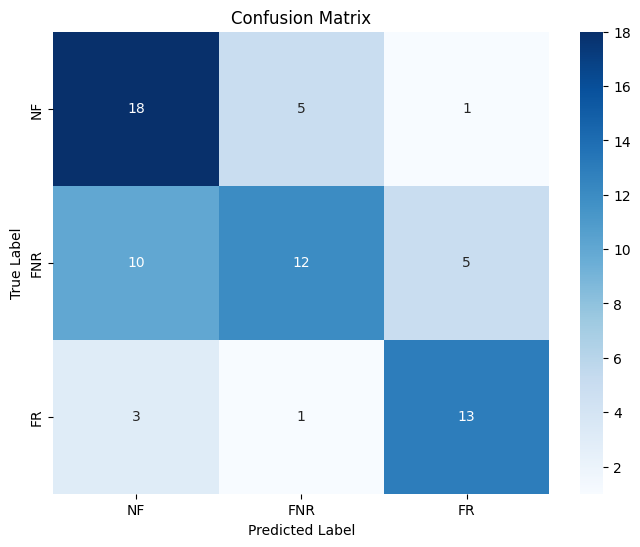

In [183]:
# Extract predictions and true labels
predictions = final_predictions
true_labels = get_labels(test, 3)

# Calculate standard metrics
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None)
_,_,w_f1,_= precision_recall_fscore_support(true_labels, predictions, average='weighted')
acc = accuracy_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

# Log or print the metrics and save those to a file
print(f"Test Accuracy: {acc}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")
print(f"Test Weighted F1 Score: {w_f1}")
print(f"Test Macro F1 Score: {precision_recall_fscore_support(true_labels, predictions, average='macro')[2]}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(true_labels, predictions)}")

# Save test results to a file
with open('./results/runs/'+latest_run+'/test_results.txt', 'w') as file:
    file.write("Test results:\n")
    file.write(f"Accuracy: {acc}\n")
    file.write(f"Precision: {precision}\n")
    file.write(f"Recall: {recall}\n")
    file.write(f"F1: {f1}\n")
    file.write(f"Weighted F1: {w_f1}\n")
    file.write(f"Macro F1: {precision_recall_fscore_support(true_labels, predictions, average='macro')[2]}\n")
    file.write(f"Balanced Accuracy: {balanced_accuracy_score(true_labels, predictions)}\n")

runs = os.listdir('./results/runs/')
runs.sort()
latest_run = runs[-1]
print('latest_run:',latest_run)

# Plot and save the confusion matrix
if num_labels == 2:
    tick_labels = ['No', 'Yes']
else:
    tick_labels = ['NF', 'FNR', 'FR']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(f'./results/runs/{latest_run}/test_confusion_matrix.png')
plt.show()

In [166]:
predictions

array([0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 1,
       1, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 2, 0, 0,
       2, 1, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0,
       0, 0])

In [167]:
true_labels

[1,
 2,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2]

In [178]:
runs = os.listdir('./results/runs/')
runs.sort()
latest_run = runs[-1]
print('latest_run:',latest_run)

latest_run: May04_19-34-47_OPL_3L_PolBERT_CV_F1_Majority_Vote
